In [59]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import importlib


import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra

import wandb

from data.dataManager import DataManager
from model.modelCreator import ModelCreator
import model.rbm.rbm_two_partite
importlib.reload(model.rbm.rbm_two_partite)
from model.rbm.rbm_two_partite import RBM_TwoPartite
from omegaconf import OmegaConf
from scripts.run import setup_model, load_model_instance
import scripts.Jet_metrics
importlib.reload(scripts.Jet_metrics)
from scripts.Jet_metrics import get_reference_point, get_naive_metrics, get_rbm_metrics

import utils.plots
importlib.reload(utils.plots)
from utils.plots import vae_plots, corr_plots, incidence_energy_plots
import utils.atlas_plots
importlib.reload(utils.atlas_plots)
from utils.atlas_plots import plot_calorimeter_shower
from utils.rbm_plots import plot_rbm_histogram
import os
from datetime import datetime
from utils.pca_utils import compute_U, plot_PCA
from matplotlib.colors import LogNorm
from scripts.RBM_2P_MNIST import save_clamped_samples_for_vae
from datetime import datetime
import utils.rbm_plots
importlib.reload(utils.rbm_plots)
from utils.rbm_plots import plot_rbm_histogram, plot_weight_distribution


In [60]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
cfg=compose(config_name="config.yaml")
wandb.init(tags = [cfg.data.dataset_name], project=cfg.wandb.project, entity=cfg.wandb.entity, config=OmegaConf.to_container(cfg, resolve=True), mode='disabled')

In [61]:
#config.wandb.watch = 0
new_model = False
if new_model:
    self = setup_model(config)
else:
    config = OmegaConf.load(cfg.config_path)
    config.gpu_list = cfg.gpu_list
    config.load_state = cfg.load_state
    self = setup_model(config)
    self._model_creator.load_state(config.run_path, self.device)


[16:02:11.033] INFO   data.dataManager                                  Loading ATLAS dataset: AtlasCustom1
[16:02:12.541] INFO   data.atlas                                        Using Linear Binning for Custom ATLAS Dataset
[16:02:12.719] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f1dfed76d80>: 80000 events, 157 batches
[16:02:12.720] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f1c50240410>: 10000 events, 10 batches
[16:02:12.721] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f1df3a8e930>: 10000 events, 10 batches
[16:02:12.722] INFO   model.modelCreator                                ::Creating Model
[16:02:12.844] INFO   model.rbm.zephyr                                  RBM is configured to be fully connected.
[16:02:12.846] INFO   model.rbm.rbm_fulltorch                           RBMTorc

Using conditional latent size in decoder


[16:02:13.067] INFO   scripts.run                                       Requesting GPUs. GPU list :[1]
[16:02:13.073] INFO   scripts.run                                       Main GPU : cuda:1
[16:02:13.074] INFO   scripts.run                                       CUDA available


cuda:1


[16:02:13.534] INFO   model.modelCreator                                Loading state
[16:02:13.640] INFO   model.modelCreator                                Loading weights from file : /fast_scratch_1/caloqvae/lzhu/wandb/run-20251114_012936-8e96xchx/files/ae_separate_best_epoch157.pth


Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _bce_loss
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


[16:02:32.221] INFO   engine.engine                                     Epoch: 0 - Average Val Loss: 1758.6396
/home/leozhu/CaloQuVAE/utils/plots.py:173: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


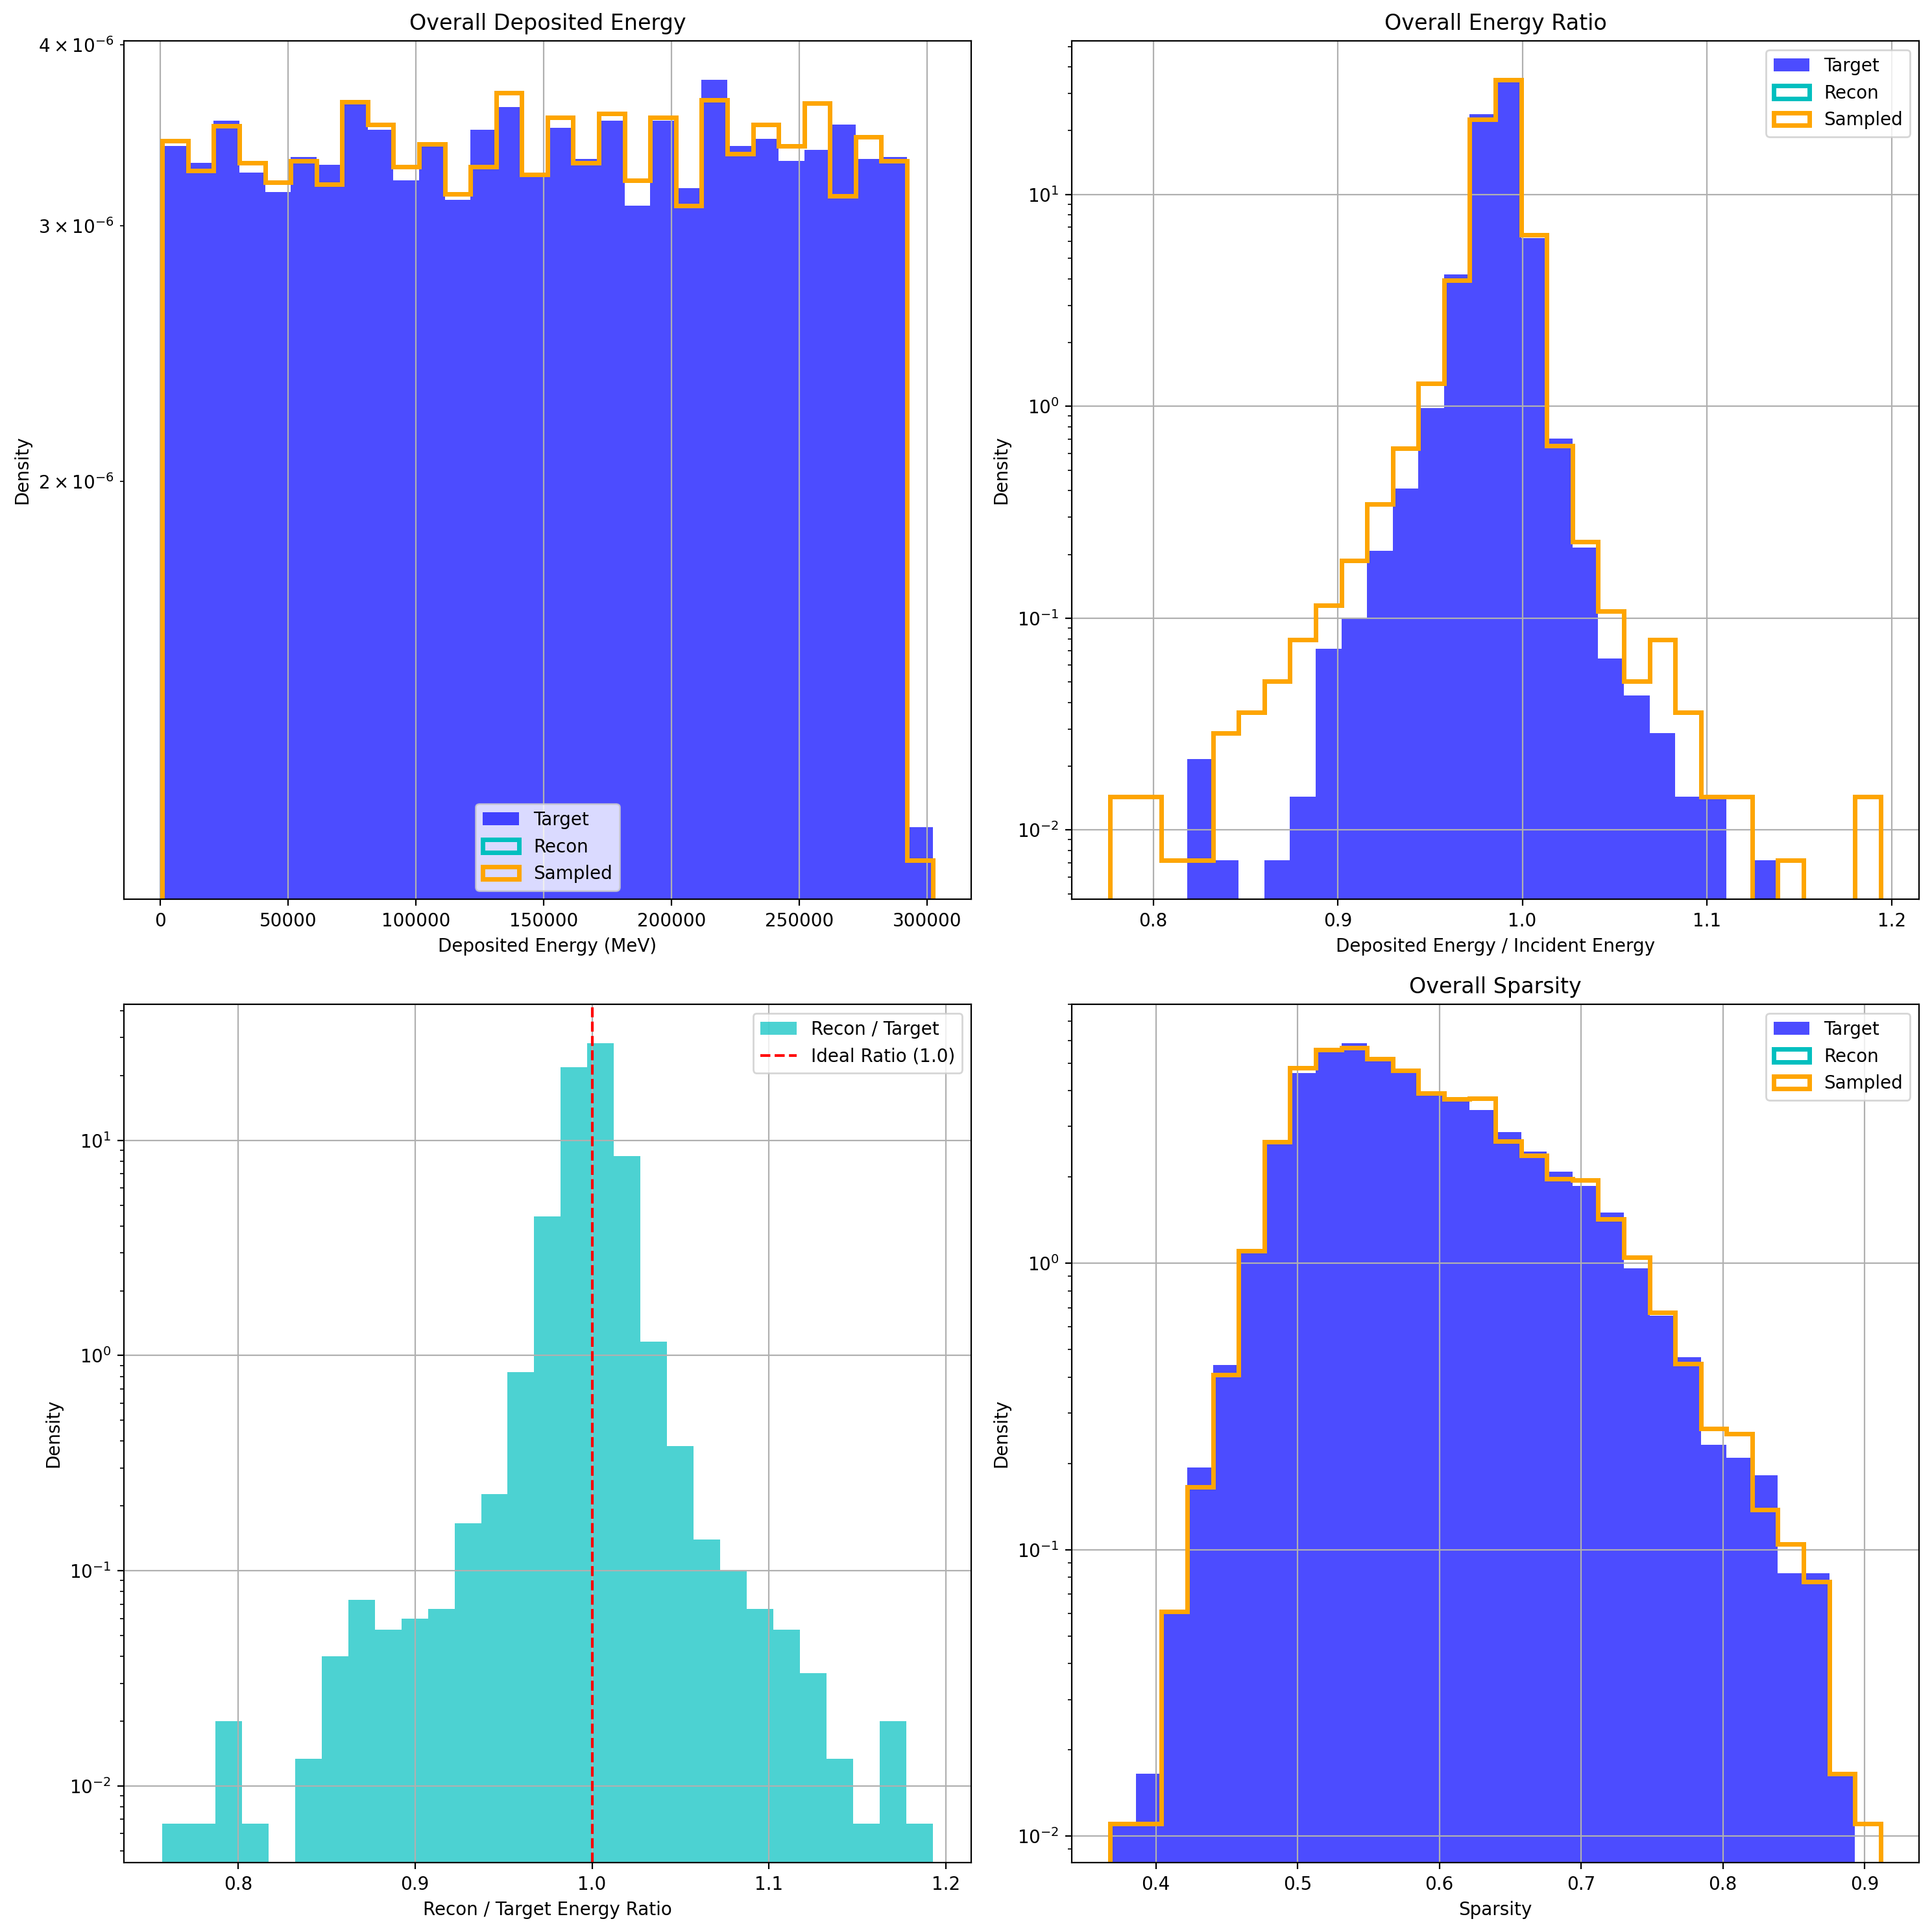

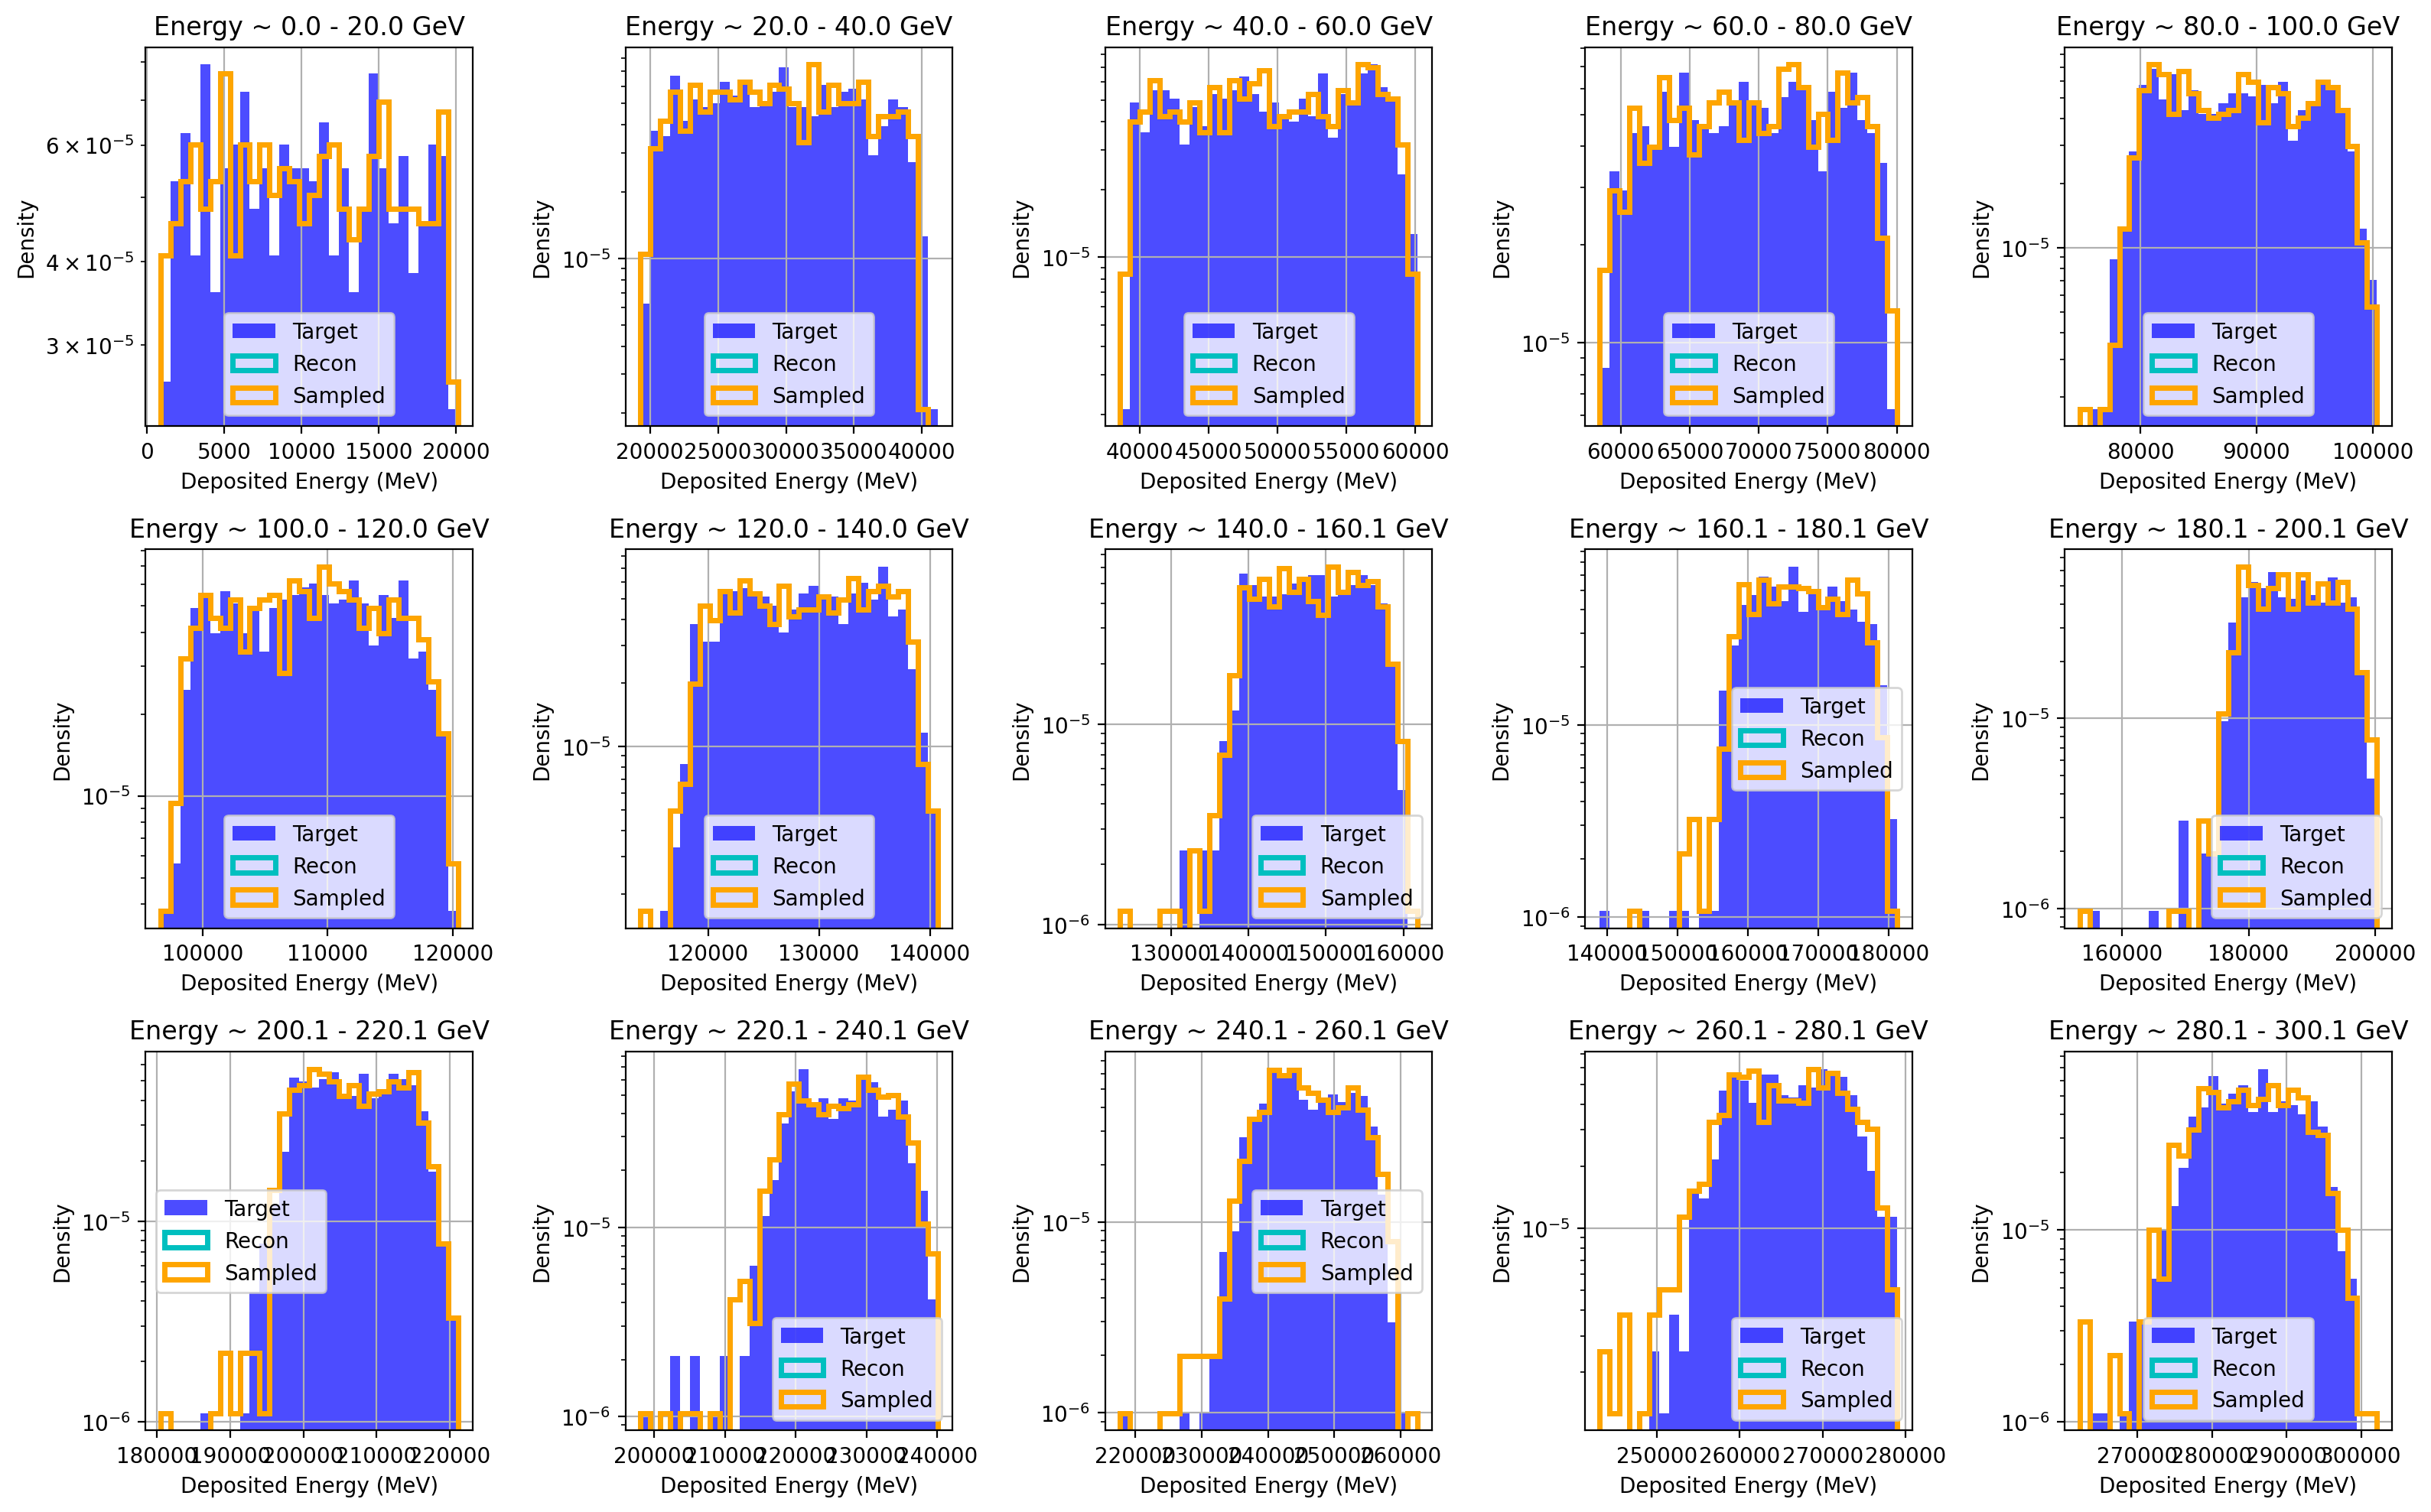

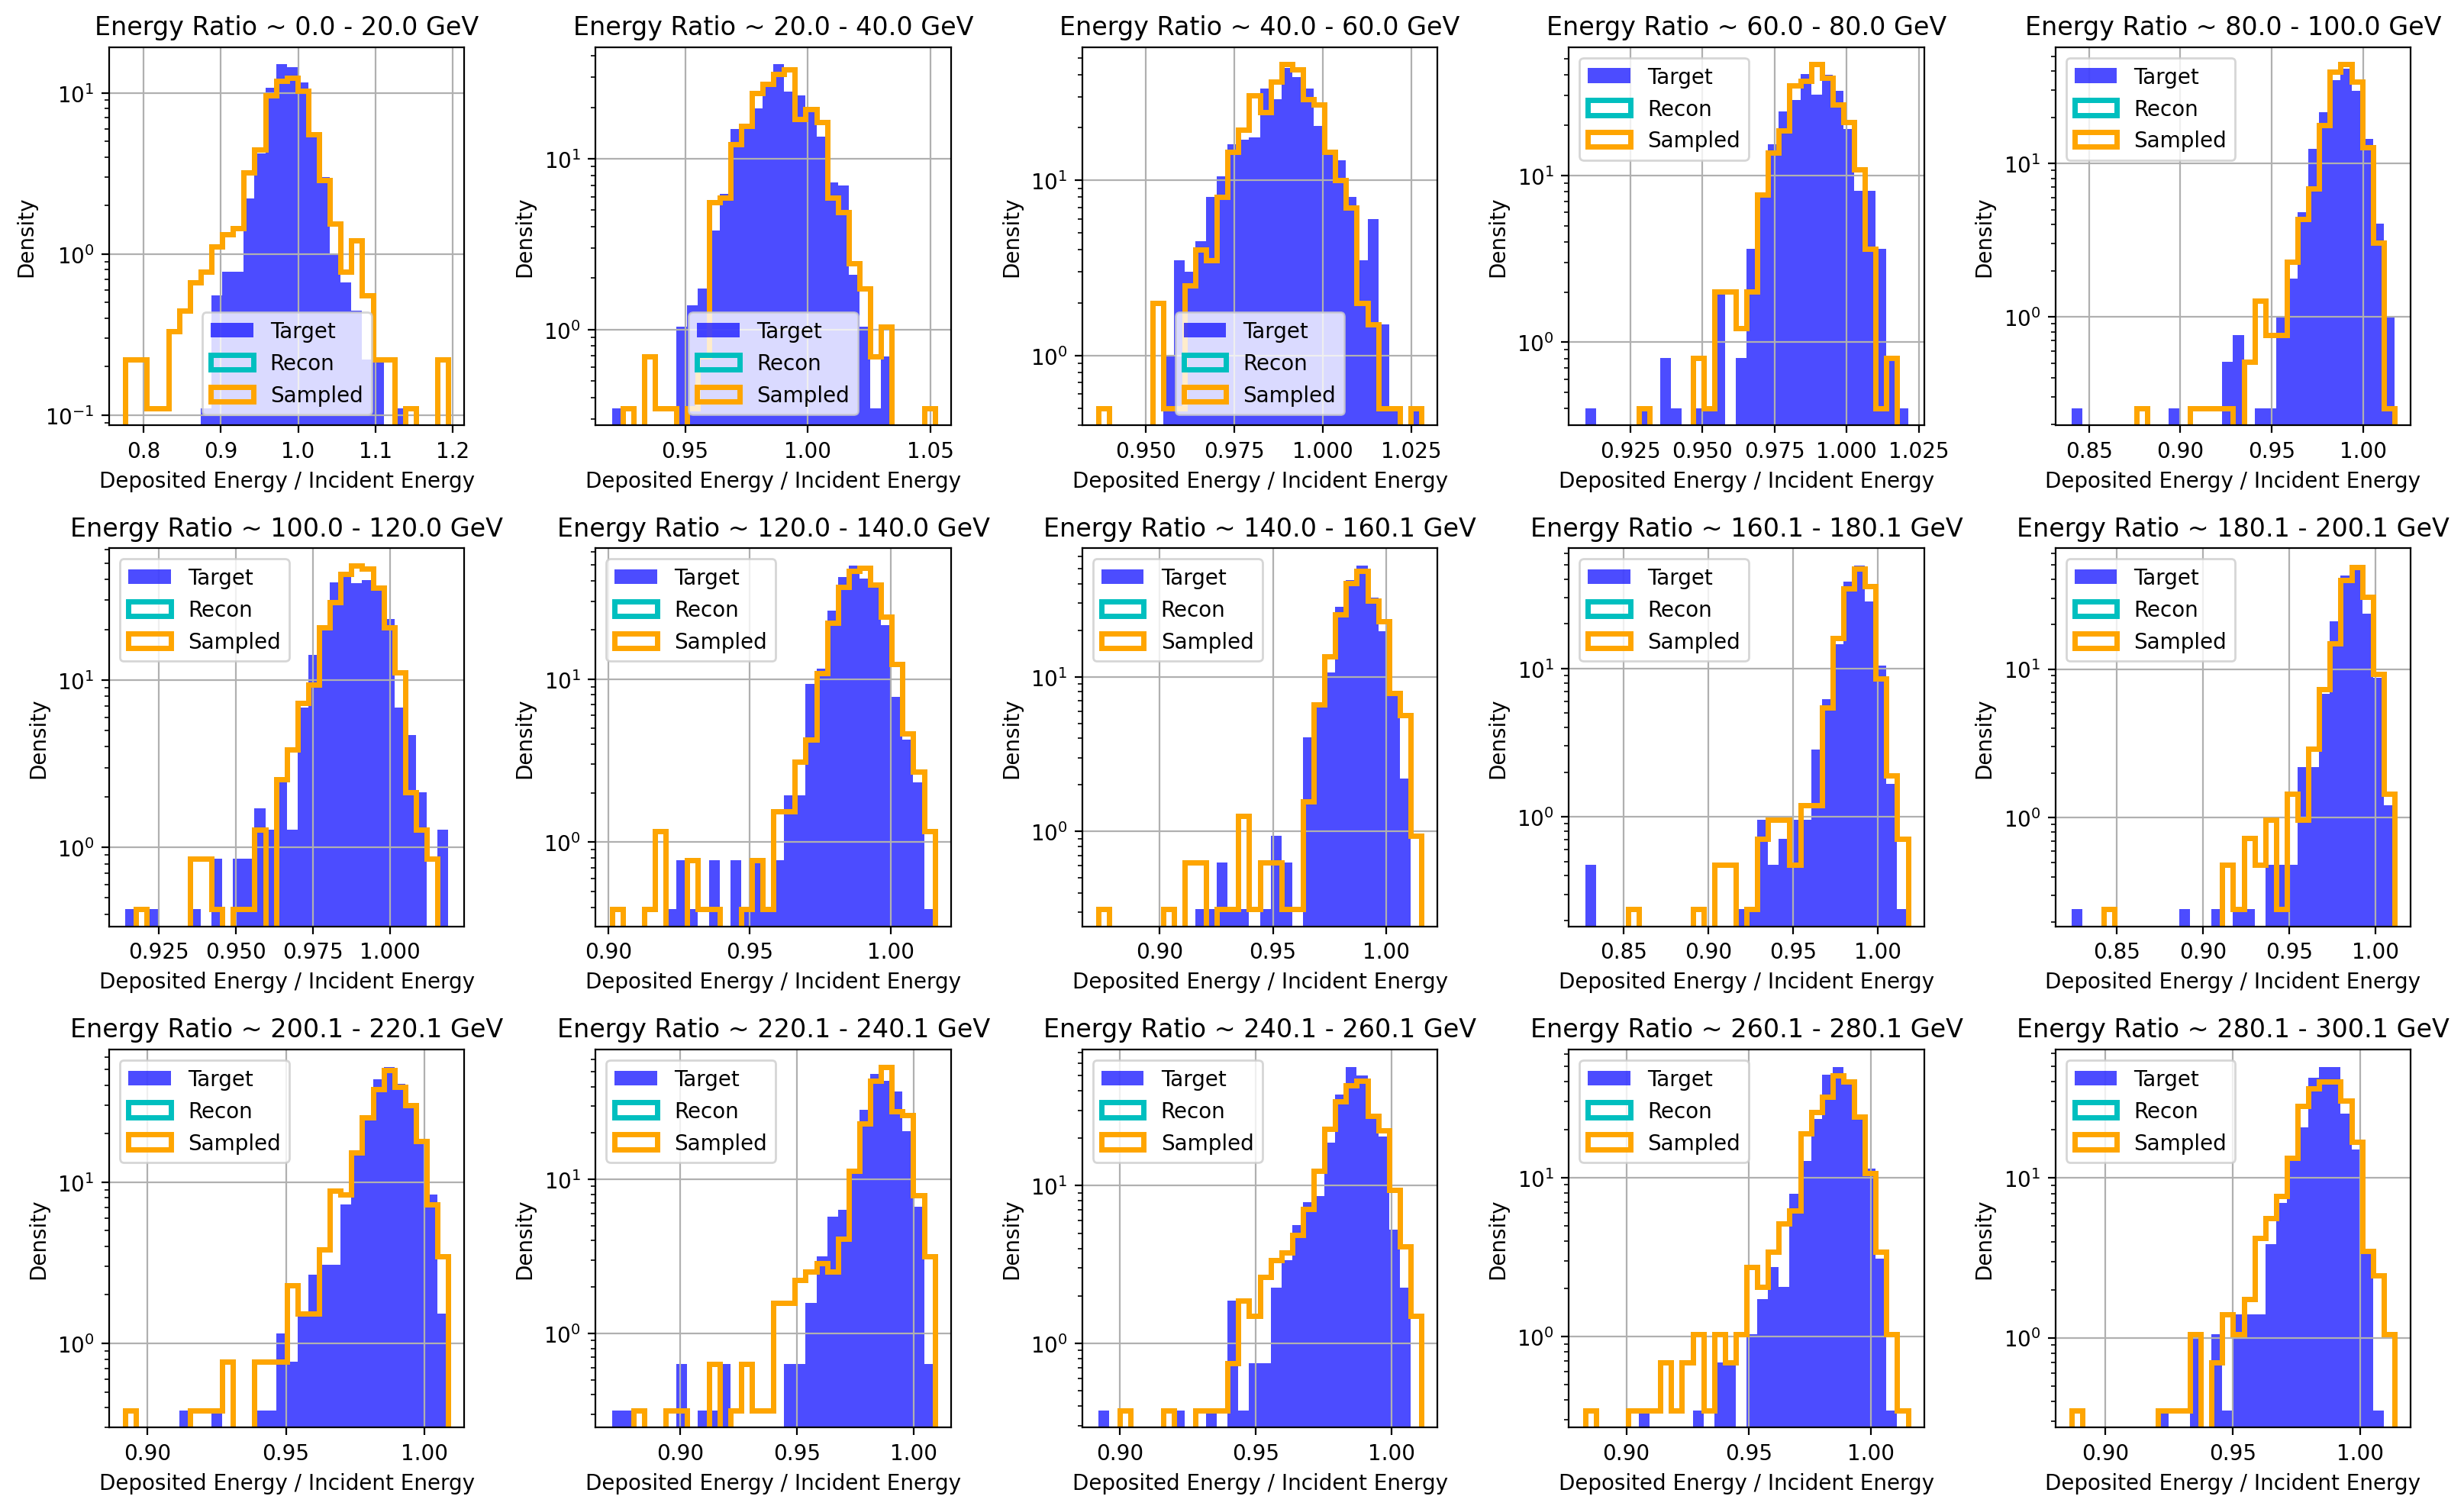

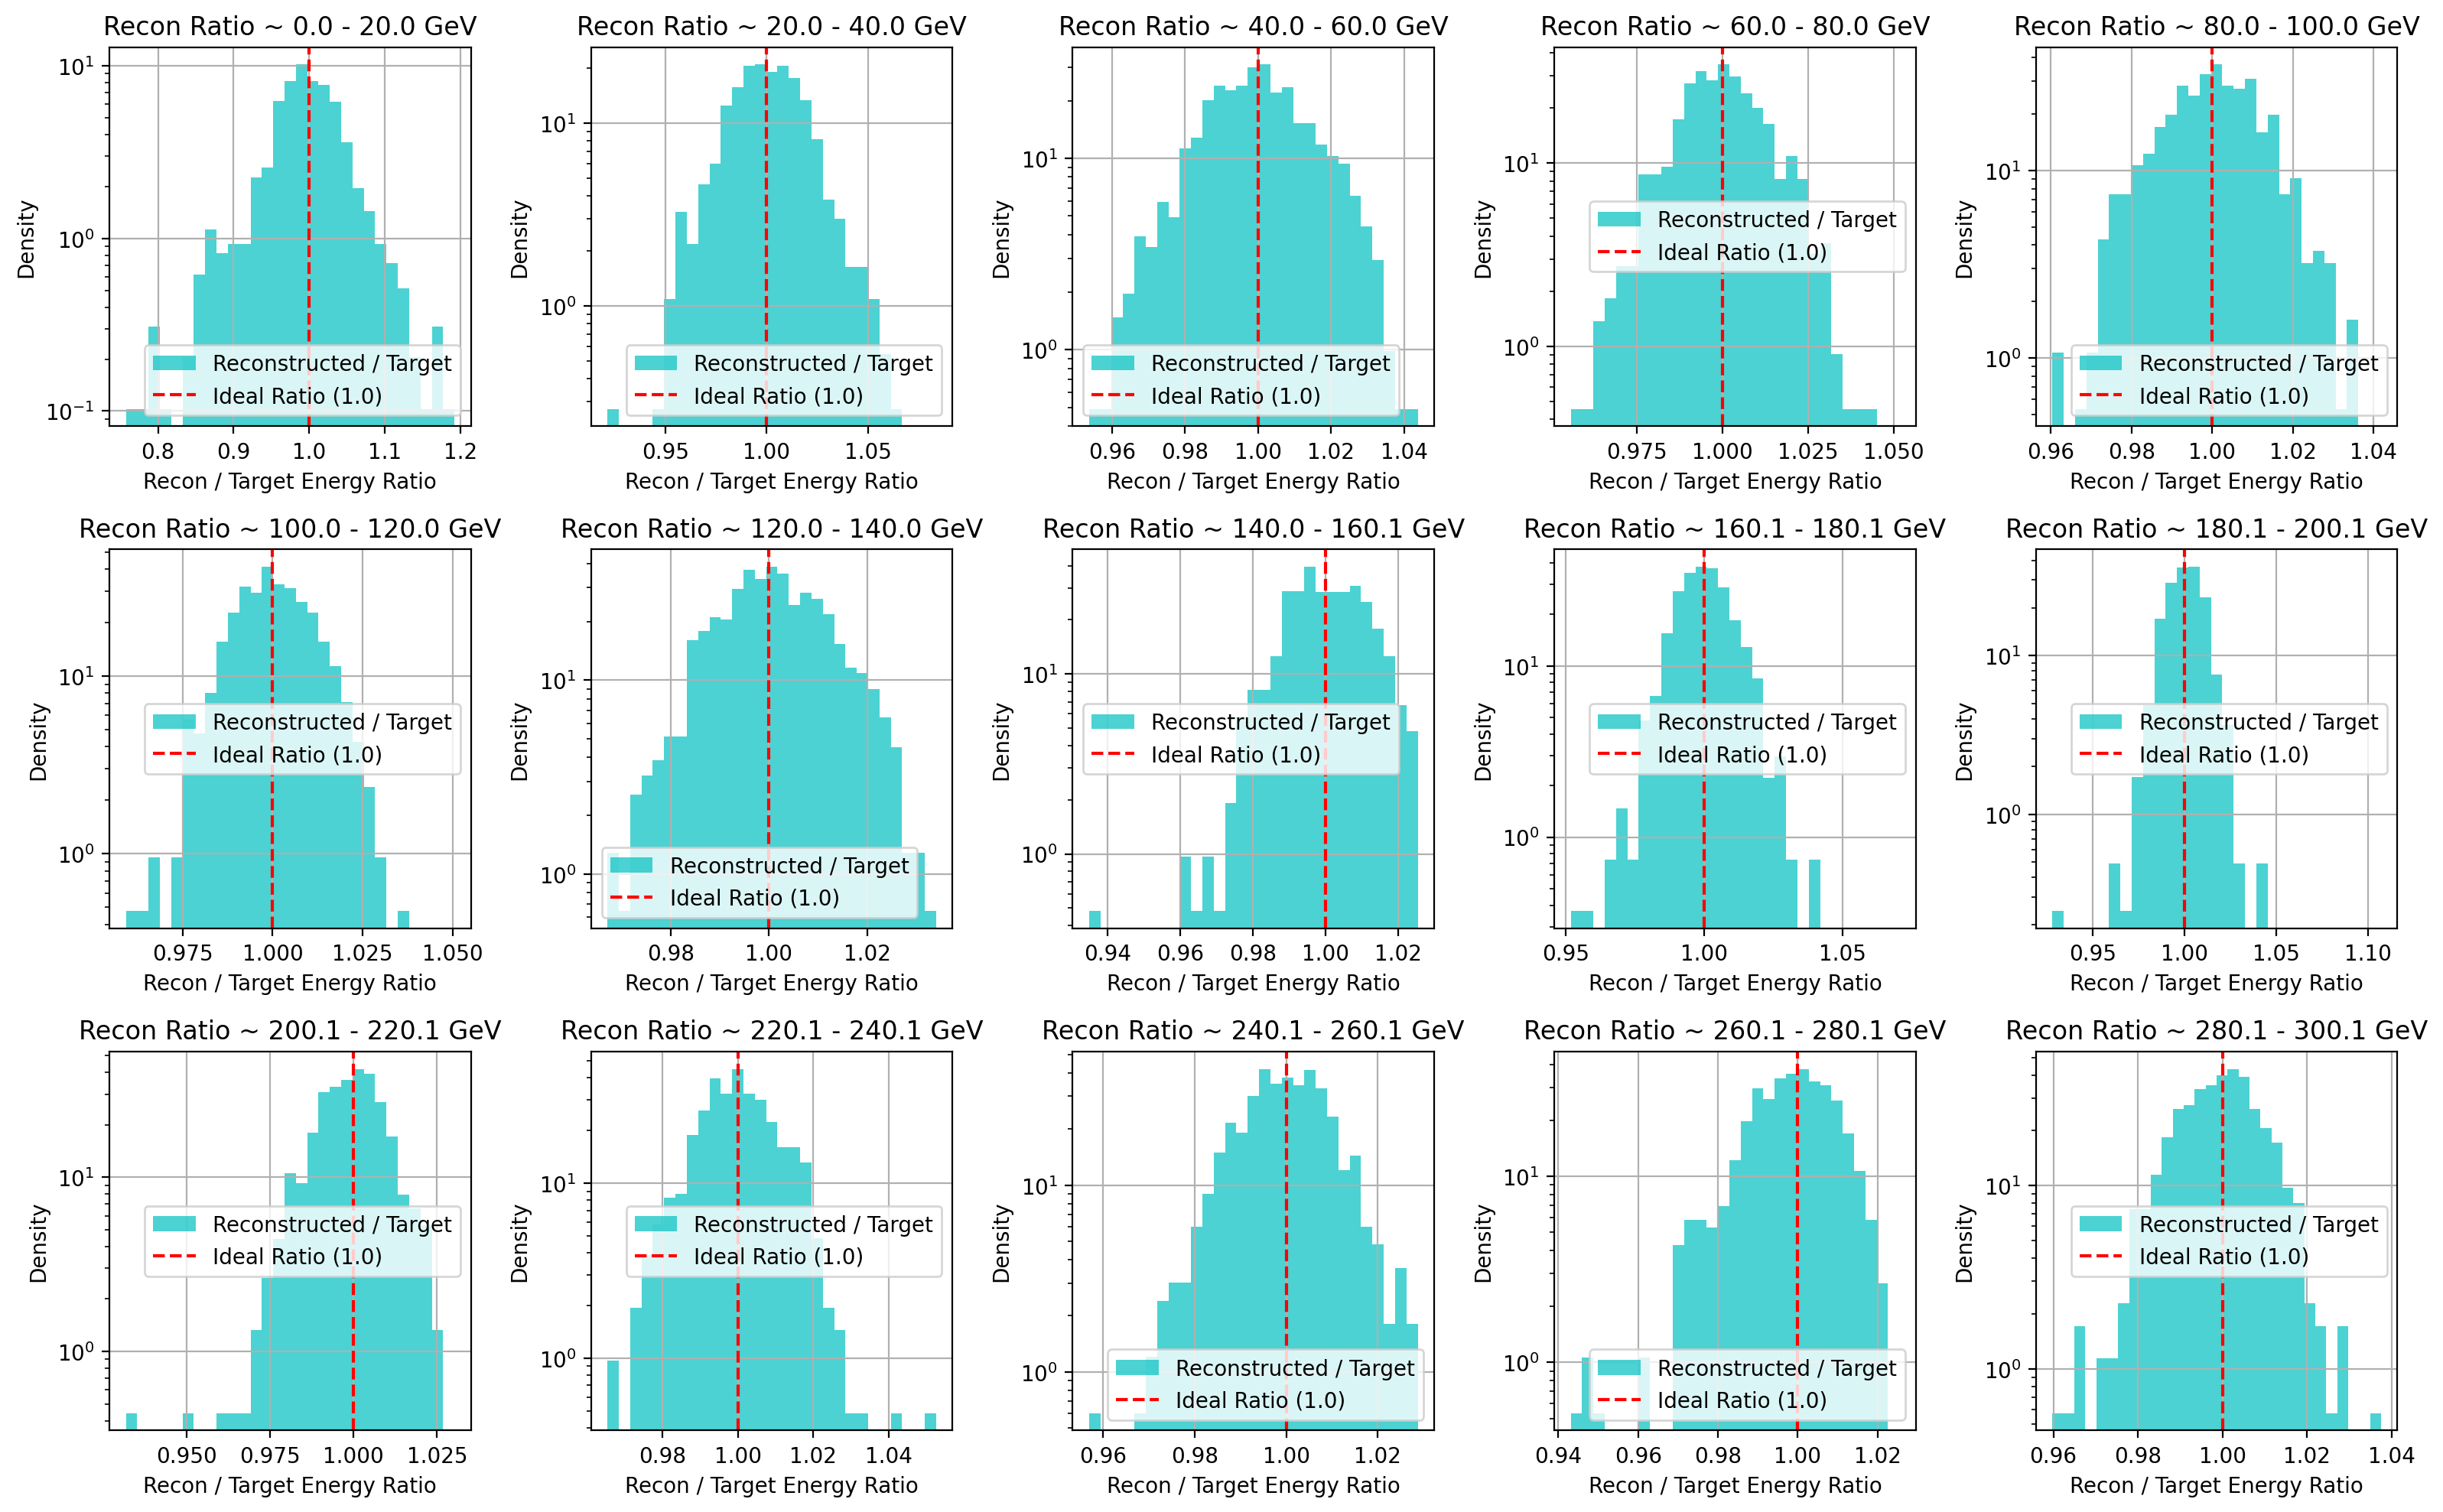

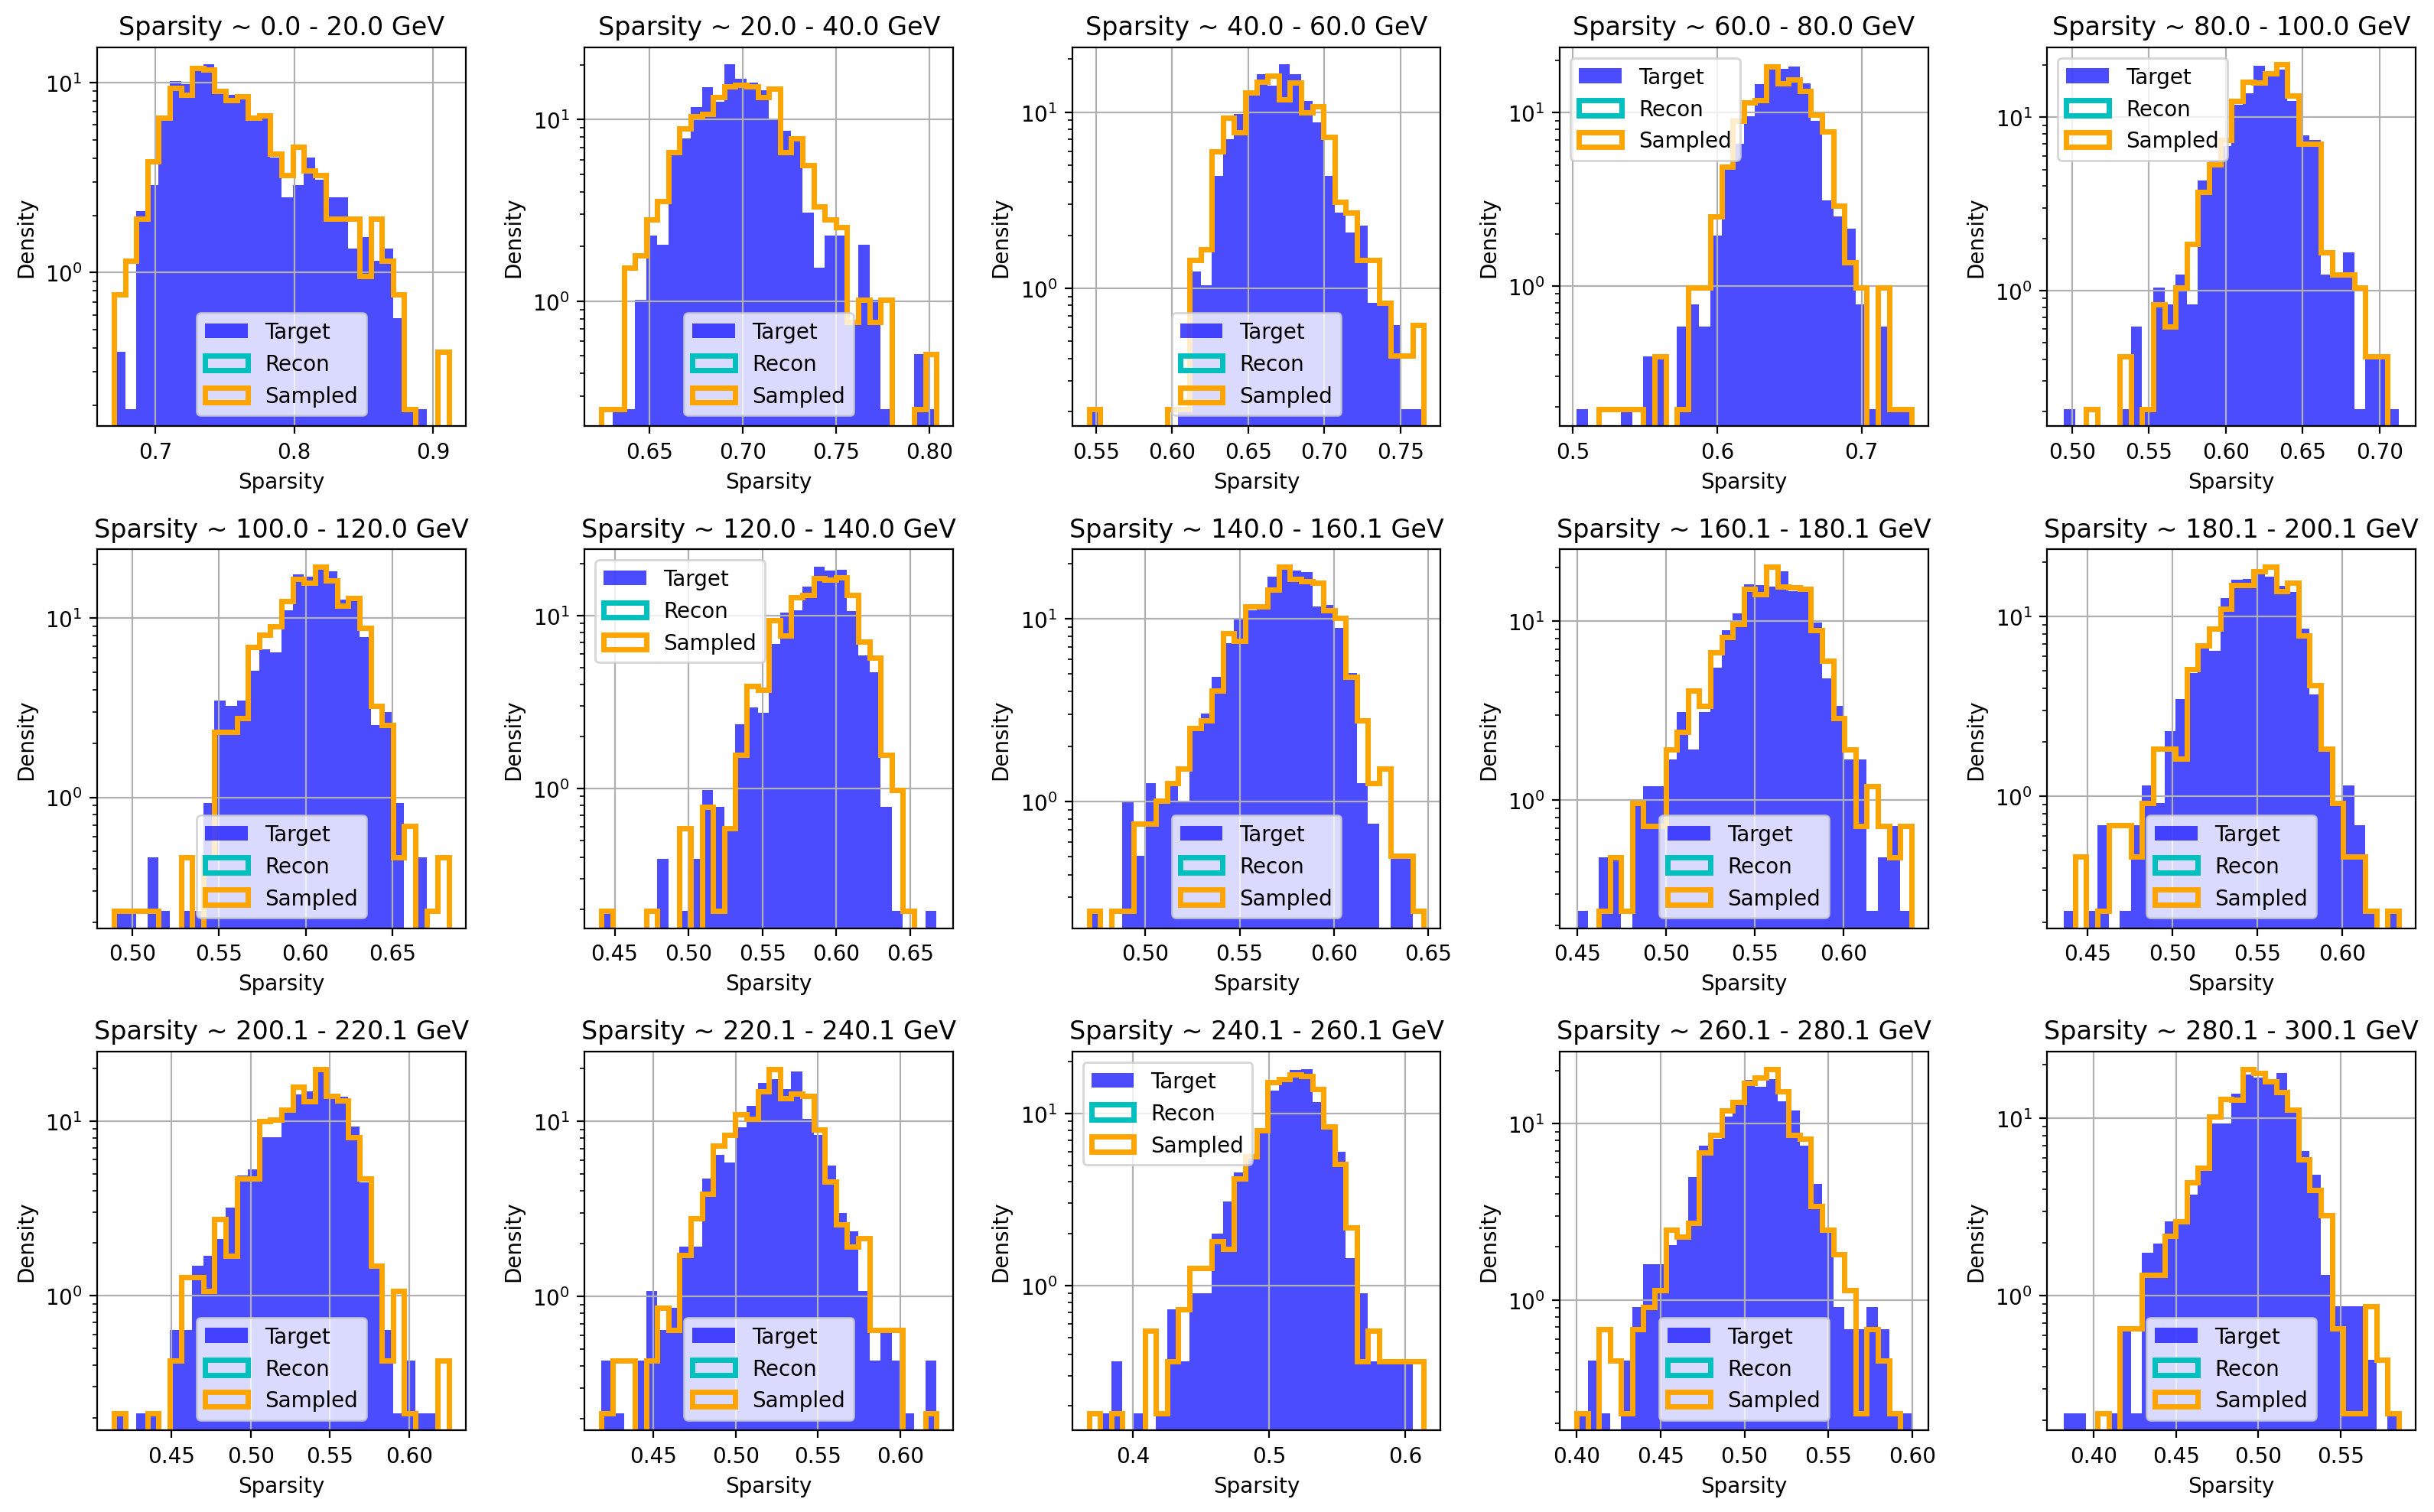

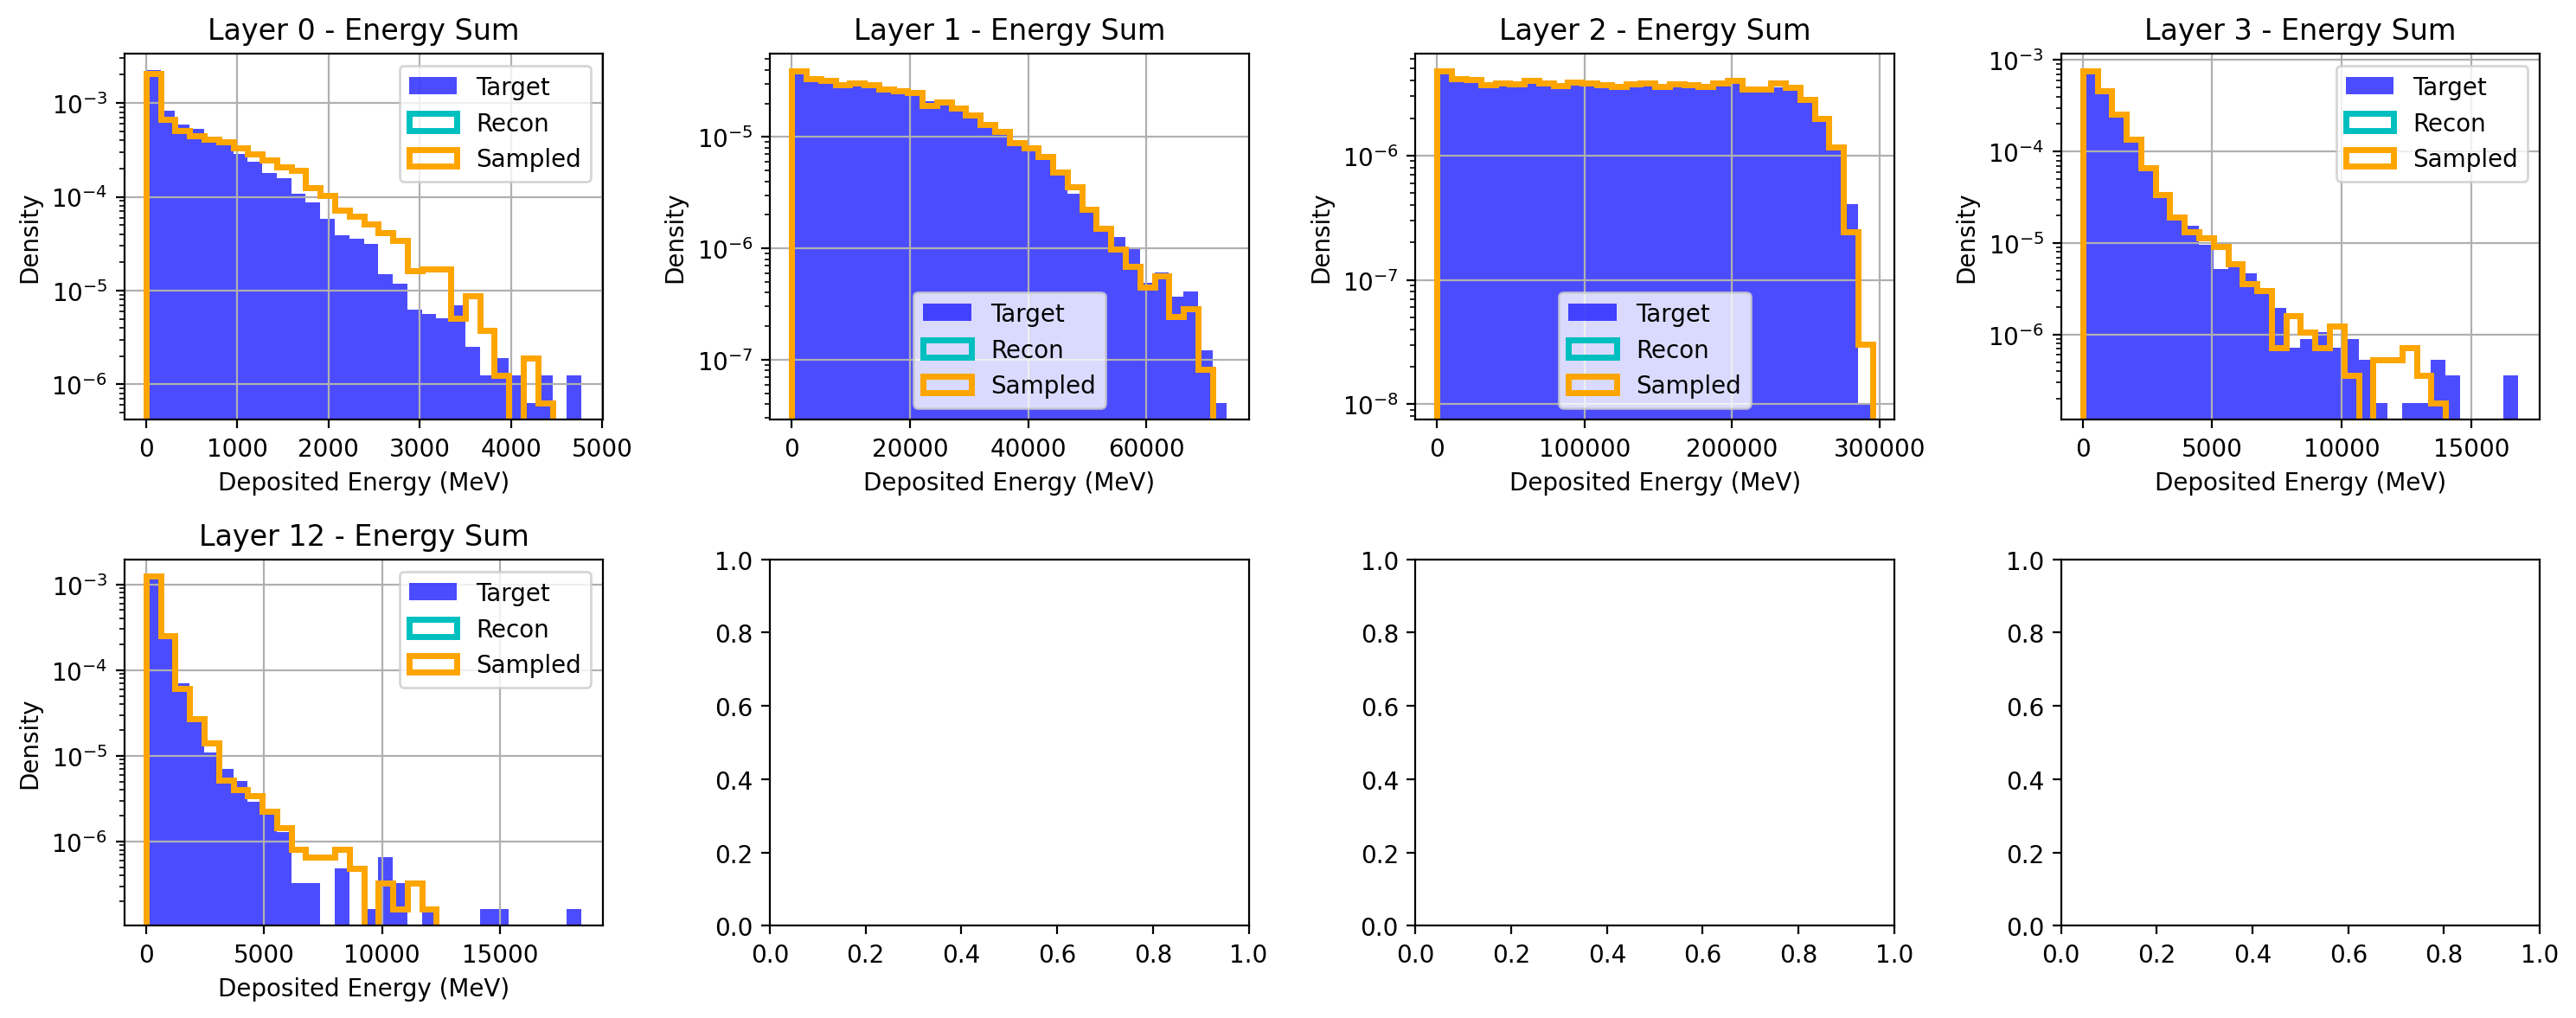

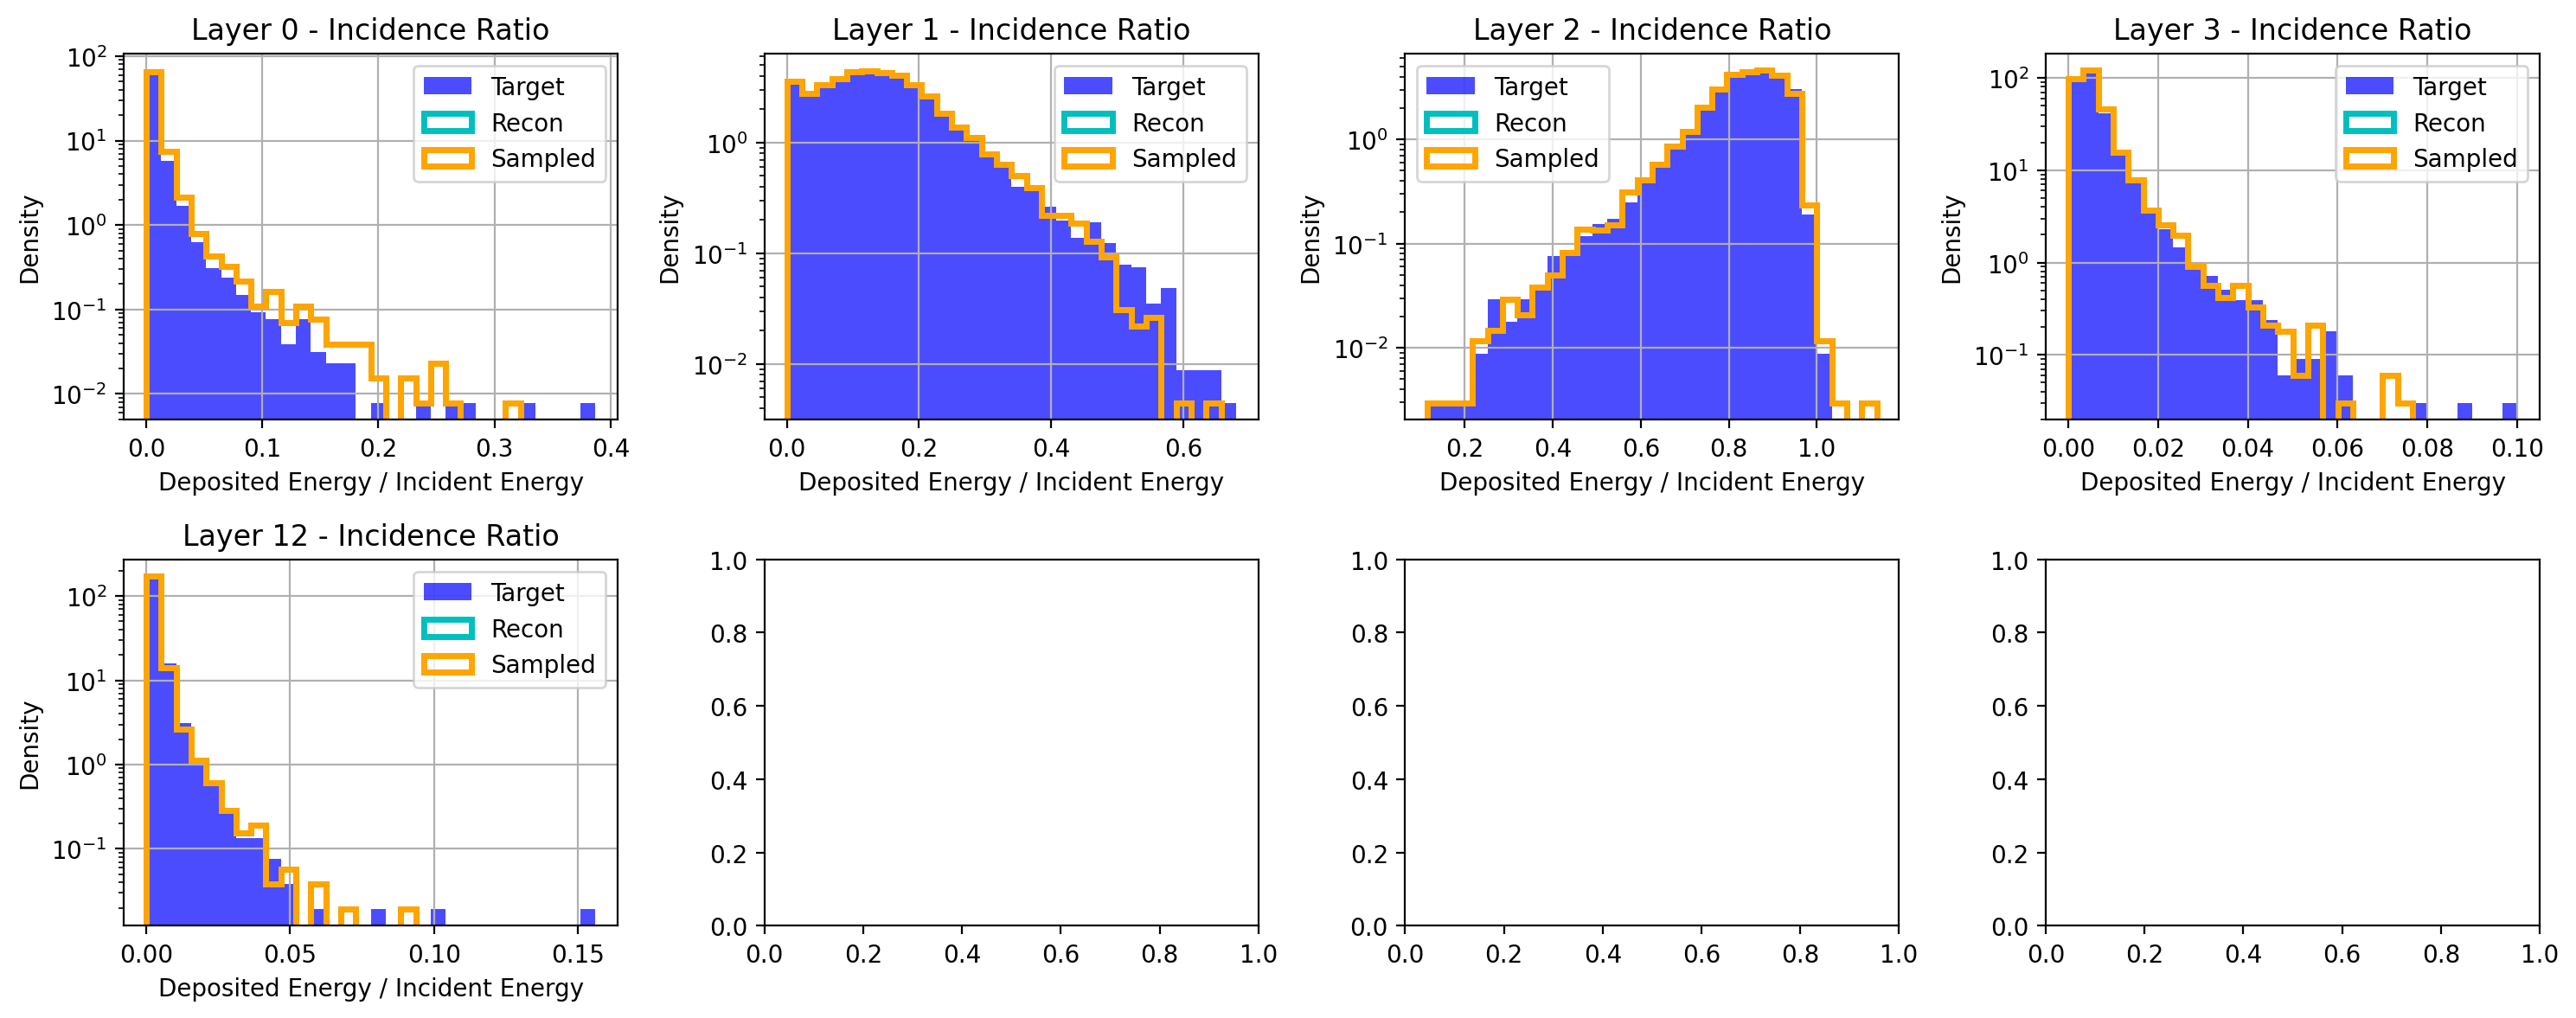

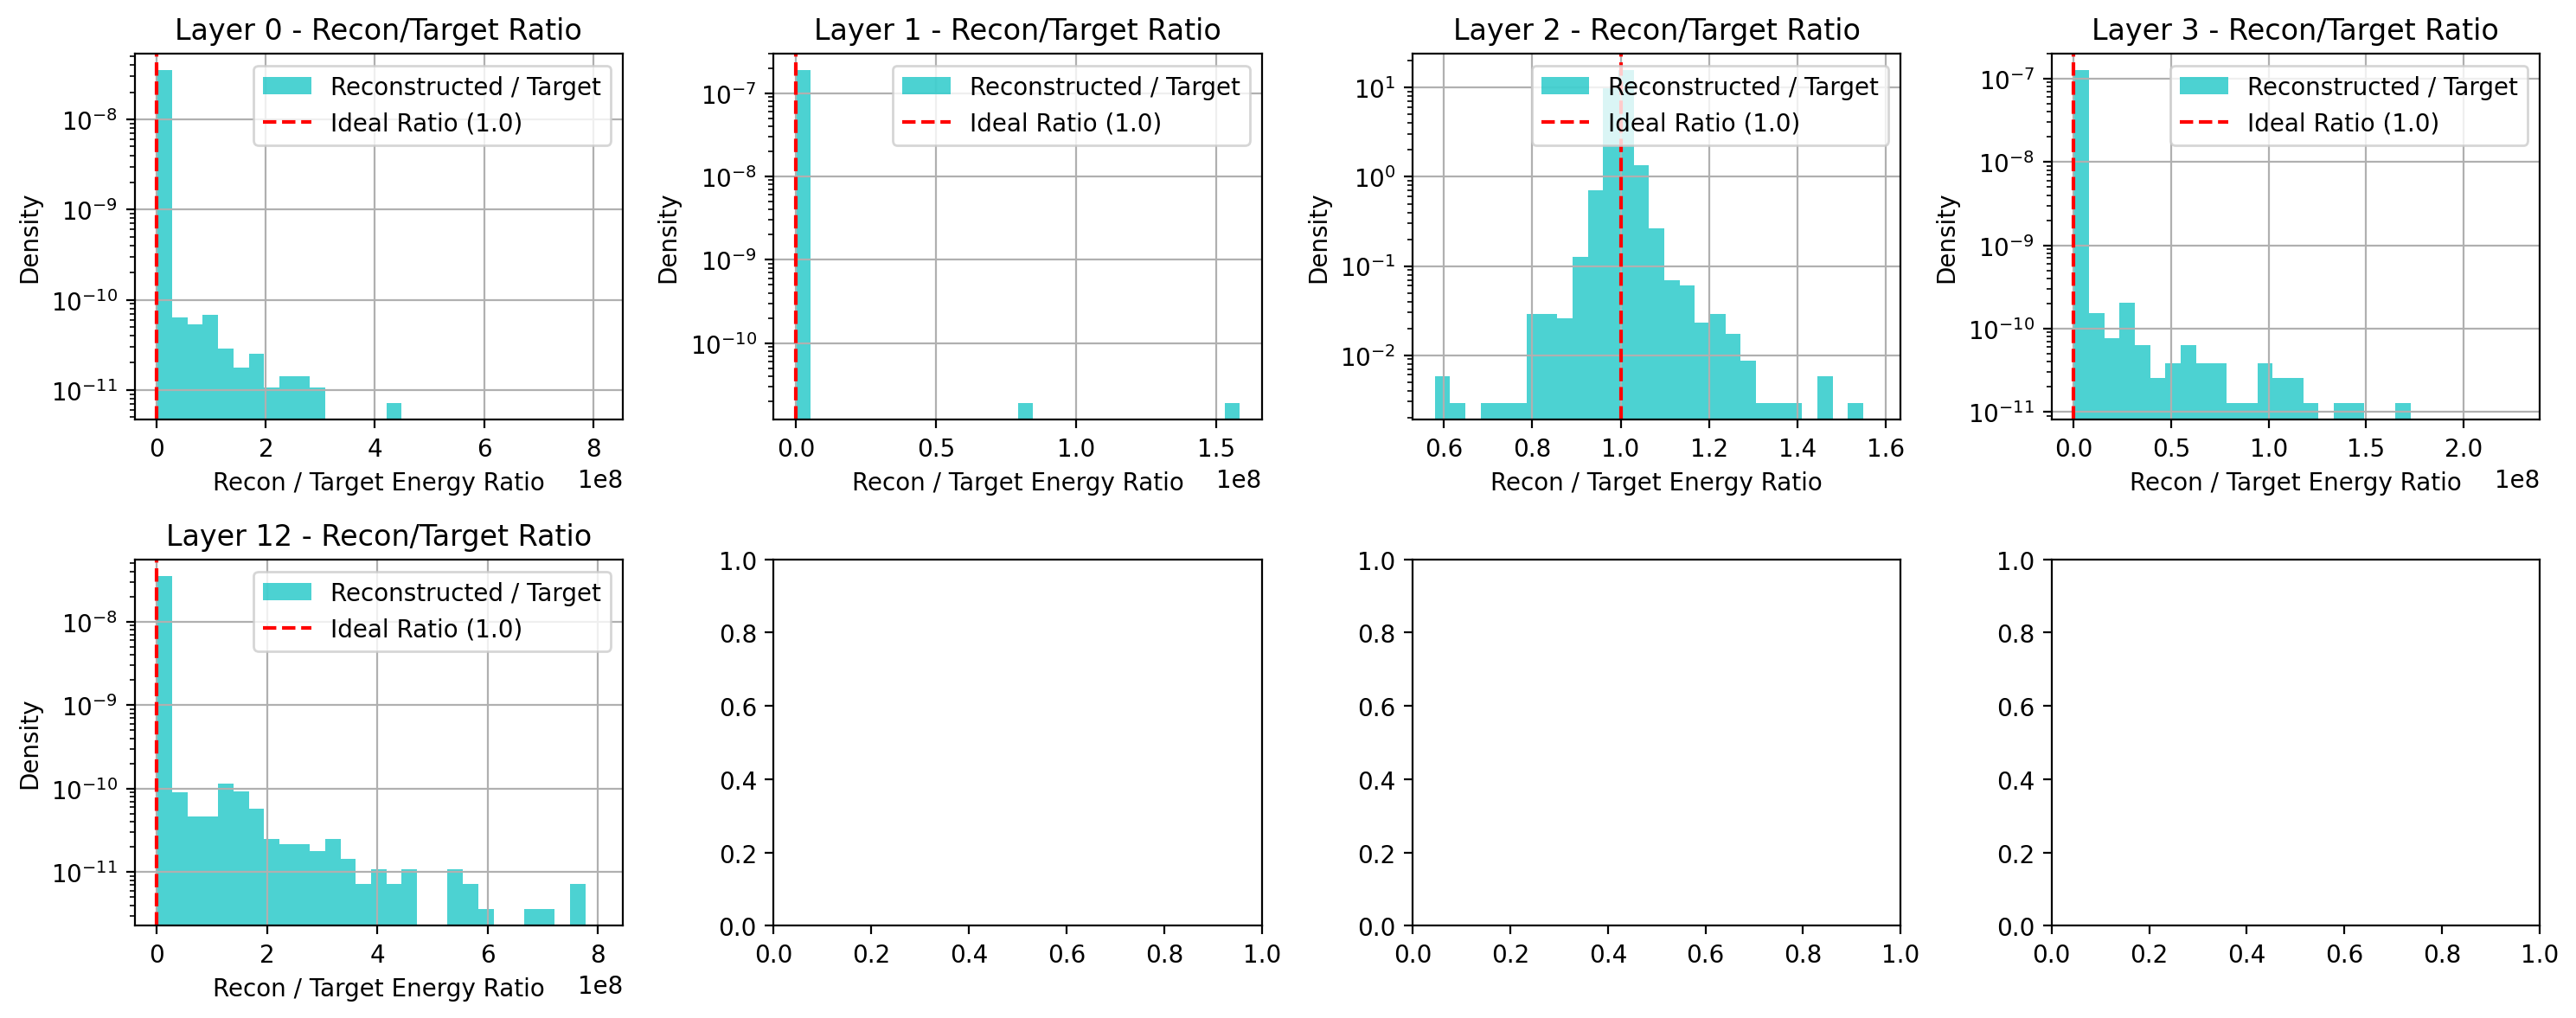

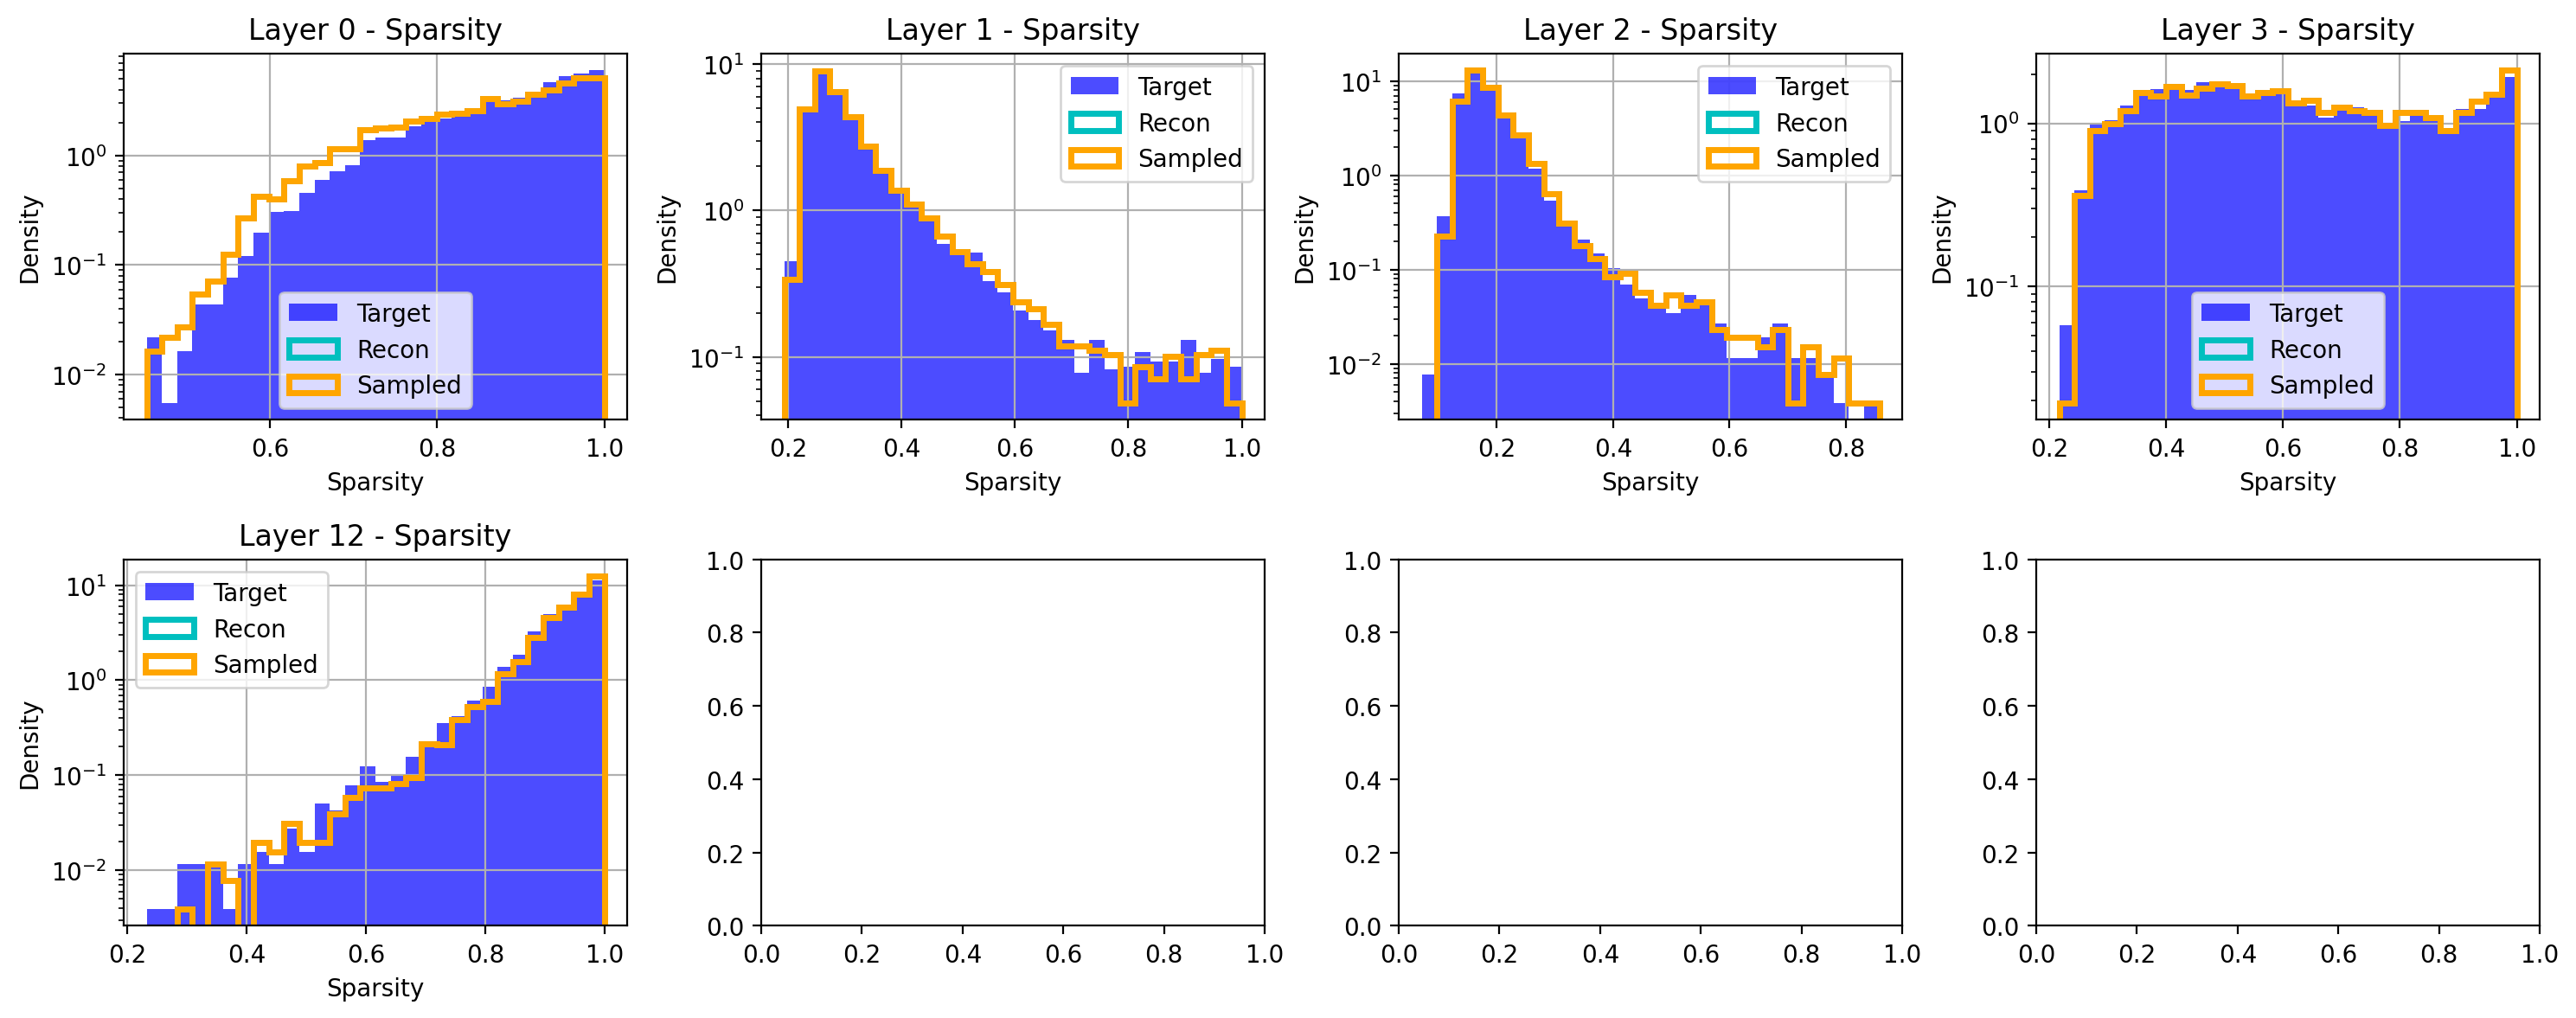

In [62]:
self.evaluate_ae(self.data_mgr.val_loader, 0)
overall_fig, fig_energy_sum, fig_incidence_ratio, fig_target_recon_ratio, fig_sparsity, fig_sum_layers, fig_incidence_layers, fig_ratio_layers, fig_sparsity_layers, _ = vae_plots(self._config,
    self.incident_energy, self.showers, self.showers_recon, self.showers_prior)


In [ ]:
data_dir = 'wandb-outputs'
save_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# --- 1. Generate and save the TRAINING data ---
print("Evaluating on training data...")
self.evaluate_vae(self.data_mgr.train_loader, epoch=0) 

In [ ]:
# Save the latent samples (the new "images")
torch.save(self.post_samples, os.path.join(data_dir, f'latent_train_data_{save_timestamp}.pt'))
torch.save(self.incident_energy, os.path.join(data_dir, f'latent_train_labels_{save_timestamp}.pt'))
# Save the incident energy (the new "labels")
print(f"Saved training latents of shape {self.post_samples.shape} to  latent_train_data_{save_timestamp}.pt")

Using device: cuda:2
Loaded real data shape: torch.Size([80000, 128])
Loaded generated data shape: torch.Size([50000, 128])
Computing principal components (U)...
Principal components computed.
Generating PCA plot...


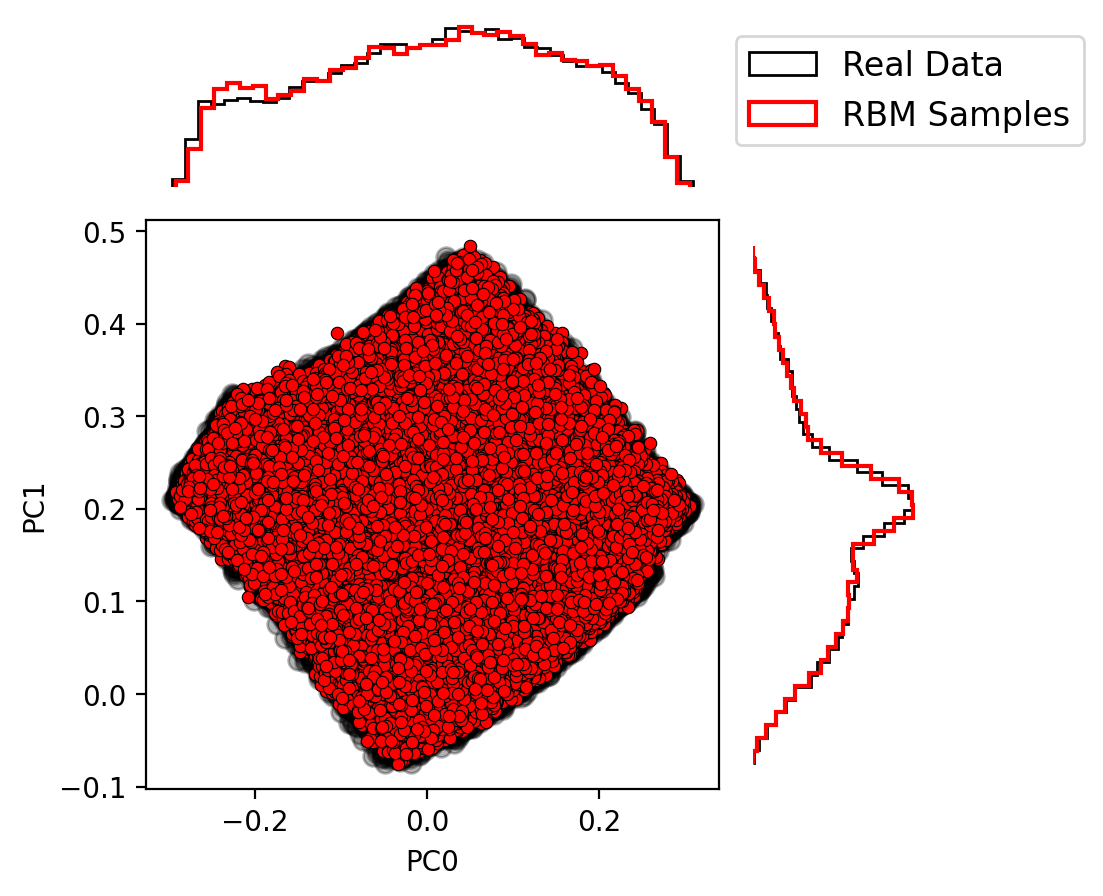

In [63]:
PATH_TO_REAL_DATA = "/home/leozhu/CaloQuVAE/wandb-outputs/latent_train_data_2025-11-15_03-04-07.pt"
PATH_TO_FANTASY_SAMPLES = "/home/leozhu/CaloQuVAE/wandb-outputs/run_2025-12-20_05-26-22_RBM_TwoPartite/rbm_fantasy_samples_train_data_final.pt"
# Set the device
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Load Your Data ---

# Load the original data your RBM was trained on
# This is the file you passed to `prep_latent_data`
data_real = torch.load(PATH_TO_REAL_DATA).to(device)

# Load the samples generated by your RBM
# This is the file saved by `save_fantasy_samples_for_vae`
data_generated = torch.load(PATH_TO_FANTASY_SAMPLES).to(device)

print(f"Loaded real data shape: {data_real.shape}")
print(f"Loaded generated data shape: {data_generated.shape}")

# --- 3. Prepare Data for PCA ---

# Ensure data is float (PCA code expects it)
data_real = data_real.to(torch.float32)
data_generated = data_generated.to(torch.float32)

# Get dimension
num_samples, num_visibles = data_real.shape
num_chains = data_generated.shape[0]

# Create sample weights (assuming all real samples have equal weight)
weights = torch.ones(num_samples, 1, device=device)
# --- 4. Compute Principal Components ---

print("Computing principal components (U)...")
# Center the *real data* (this is a key step in PCA)
M = data_real - data_real.mean(0)

# Compute the top 4 principal components (eigenvectors)
U = compute_U(
    M=M,
    d=4,  # We'll compute 4 PCs, but only plot the first 2
    weights=weights,
    device=device,
    dtype=torch.float32
)
print("Principal components computed.")

# --- 5. Project Data onto PC Basis ---

# Project the real data
data_proj = data_real @ U / num_visibles**0.5

# Project the generated (chains) data onto the *same* basis
chains_proj = data_generated @ U / num_visibles**0.5

# --- 6. Plot the Results ---

print("Generating PCA plot...")
plot_PCA(
    data_proj.cpu().numpy(),        # Pass real data projection
    chains_proj.cpu().numpy(),    # Pass generated data projection
    labels=["Real Data", "RBM Samples"],
    dir1=0,  # Plot PC0
    dir2=1   # Plot PC1
)
plt.show()

In [65]:
rbm_cfg=compose(config_name="config.yaml")
dummy_data = torch.zeros(1, rbm_cfg.rbm.num_visible_nodes).to(self.device)
CHECKPOINT_FILE = "/home/leozhu/CaloQuVAE/wandb-outputs/run_2025-12-20_05-26-22_RBM_TwoPartite/training_checkpoint.h5"
rbm = RBM_TwoPartite(rbm_cfg, data=dummy_data)

print(f"Instantiated RBM with {rbm.num_visible} visible units.")

# --- Step 5: Load the checkpoint ---
# This loads the saved weights, chains, and RNG state *into* the object
try:
    # Load the latest epoch (epoch=None)
    loaded_epoch = rbm.load_checkpoint(CHECKPOINT_FILE, epoch=None) 
    print(f"Successfully loaded checkpoint from epoch {loaded_epoch}.")
except Exception as e:
    print(f"Error loading checkpoint: {e}")

# --- Step 6: Access the data ---
if 'rbm' in locals():
    print("\nAccessing loaded data:")
    
    # Access parameters
    weights = rbm.params["weight_matrix"]
    vbias = rbm.params["vbias"]
    print(f"  Weight matrix shape: {weights.shape}")
    print(f"  Visible bias mean: {vbias.mean().item():.4f}")
    
    # Access persistent chains
    chains = rbm.chains["v"]
    print(f"  Persistent chains shape: {chains.shape}")

[16:03:31.874] INFO   model.rbm.rbm_two_partite                         Initializing RBM parameters with std: 0.0001
[16:03:31.877] INFO   model.rbm.rbm_two_partite                         Loading parameters from epoch_1999...
[16:03:31.885] INFO   model.rbm.rbm_two_partite                         Loaded persistent chains.
[16:03:31.886] INFO   model.rbm.rbm_two_partite                         Restoring RNG states...


Instantiated RBM with 76 visible units.
Successfully loaded checkpoint from epoch 1999.

Accessing loaded data:
  Weight matrix shape: torch.Size([128, 75])
  Visible bias mean: 0.4436
  Persistent chains shape: torch.Size([5000, 128])


In [ ]:
def generate_energy_histogram(
    rbm: RBM_TwoPartite, 
    training_data_visibles: torch.Tensor, 
    generated_samples_v: torch.Tensor,
    batch_size: int = 1024
) -> plt.Figure:
    """
    Generates a histogram comparing the energies of real data and generated samples.

    Args:
        rbm (RBM_TwoPartite): The trained RBM model.
        training_data_visibles (torch.Tensor): A tensor of the real training data's 
                                             visible nodes, shape [num_samples, num_visibles].
        batch_size (int): Batch size for computing real data energies to avoid OOM errors.
    
    Returns:
        matplotlib.figure.Figure: The generated histogram figure.
    """
    
    # 1. Compute energies for the real data (rbm_post)
    # We compute this in batches to avoid OOM errors if the dataset is large
    energies_post_list = []
    
    # We use torch.no_grad() for efficiency, as we don't need gradients here
    with torch.no_grad():
        for i in range(0, training_data_visibles.shape[0], batch_size):
            batch_v = training_data_visibles[i : i + batch_size]
            # Your compute_energy method handles moving the batch to the correct device
            batch_energies = rbm.compute_energy(batch_v)
            energies_post_list.append(batch_energies)
    
    # Concatenate all batch energies and move to CPU for plotting
    rbm_post = torch.cat(energies_post_list).cpu()

    print("Computing energies for generated samples (rbm_prior)...")
    energies_prior_list = []
    with torch.no_grad():
        for i in range(0, generated_samples_v.shape[0], batch_size):
            batch_v = generated_samples_v[i : i + batch_size]
            batch_energies = rbm.compute_energy(batch_v)
            energies_prior_list.append(batch_energies)
    rbm_prior = torch.cat(energies_prior_list).cpu() 
    fig = plot_rbm_histogram(rbm_post, rbm_prior)   
    return fig

fig = generate_energy_histogram(
    rbm=rbm,
    training_data_visibles=data_real,
    generated_samples_v=data_generated,
    batch_size=1024
)

In [ ]:
plot_weight_distribution(rbm)

In [ ]:
# --- 6. Plot the Results ---
import pandas as pd
import seaborn as sns

print("Preparing data for pair plot...")

# Get the number of PCs you computed
num_pcs = U.shape[1] 
pc_columns = [f"PC{i}" for i in range(num_pcs)]

# Convert your projected data to pandas DataFrames
# 1. Real Data
df_real = pd.DataFrame(data_proj.cpu().numpy(), columns=pc_columns)
df_real['Source'] = 'Real Data' # Add the label column

# 2. Generated Data
df_gen = pd.DataFrame(chains_proj.cpu().numpy(), columns=pc_columns)
df_gen['Source'] = 'RBM Samples' # Add the label column

# 3. Combine them into one big DataFrame
df_combined = pd.concat([df_real, df_gen], ignore_index=True)

print(f"Combined DataFrame shape: {df_combined.shape}")
print(df_combined.head()) # Check the structure

# --- 7. Generate the Pair Plot ---

print("Generating pair plot...")
# This one line creates the entire grid
g = sns.pairplot(
    df_combined, 
    hue='Source',              # This is the key: color by 'Source'
    diag_kind=None,           
    palette={'Real Data': 'black', 'RBM Samples': 'red'}, # Match your colors
    plot_kws={'alpha': 0.3, 's': 10} # Apply styling to scatter plots
)

# Customize the diagonal plots to match your original histograms
# 'histtype': 'step' makes it an outline
# 'density': True normalizes it

for i in range(num_pcs):
    g.axes[i, i].clear()
g.map_diag(
    sns.histplot, 
    common_norm=False, 
    element='step', 
    fill=False, 
    stat='density', 
    lw=1.5
)

# Optional: Adjust legend
g.legend.set_bbox_to_anchor((1.05, 0.5))

plt.suptitle("PCA Pair Plot (Real vs. RBM Samples)", y=1.02)
plt.show()

In [ ]:
run_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_type_name = "RBM_TwoPartite"
wandb_output_path = "/home/leozhu/CaloQuVAE/wandb-outputs"
save_dir = os.path.join(
    wandb_output_path, f"run_{run_timestamp}_{model_type_name}"
)
os.makedirs(save_dir, exist_ok=True)
self.evaluate_ae(self.data_mgr.val_loader, 0)
data_real = self.post_samples
save_clamped_samples_for_vae(
    rbm,
    input_data=data_real,
    n_clamped=53,
    gibbs_steps=10000,
    save_dir=save_dir,
    gen_batch_size=512
)

In [35]:
self.evaluate_ae(self.data_mgr.val_loader, 0)

In [36]:
rbm_samples = torch.load("/home/leozhu/CaloQuVAE/wandb-outputs/run_2025-11-16_00-57-35_RBM_TwoPartite/rbm_clamped_samples_train_data_final.pt")
print(rbm_samples.shape)

def decode_binary_energy(x_encoded, lin_bits=23):
    """
    Decodes the original energy value from the linear bits portion 
    of the encoded tensor.
    
    Args:
        x_encoded (torch.Tensor): The full encoded tensor, shape (batch_size, n_latent_nodes).
        lin_bits (int): The number of bits used for the linear encoding (e.g., 23).
        
    Returns:
        torch.Tensor: The decoded energy values, shape (batch_size, 1).
    """
    
    # --- 1. Extract the linear encoding ---
    # We only take the first `lin_bits` columns, which represent the
    # direct binary encoding.
    linear_encoding = x_encoded[:, :lin_bits]
    
    # --- 2. Create the bit-weight mask ---
    # This is the inverse of the mask in the `binary` function.
    # It's a tensor like [1, 2, 4, 8, ..., 2**(lin_bits-1)]
    mask = 2**torch.arange(lin_bits).to(x_encoded.device, x_encoded.dtype)
    
    # --- 3. Multiply and Sum ---
    # We multiply the binary encoding (0s and 1s) by their corresponding
    # bit weights and sum them up.
    # (batch_size, lin_bits) * (lin_bits,) -> (batch_size, lin_bits)
    weighted_bits = linear_encoding * mask
    
    # Sum along dimension 1 to get the final integer value for each item in the batch
    # (batch_size, lin_bits) -> (batch_size,)
    decoded_values = torch.sum(weighted_bits, dim=1)
    
    # --- 4. Reshape and Return ---
    # Add a dimension to match the original input shape (batch_size, 1)
    return decoded_values.unsqueeze(1)

decoded_energies = decode_binary_energy(rbm_samples, lin_bits=19)
print(decoded_energies.shape)

incidence_fig = incidence_energy_plots(self.incident_energy, decoded_energies)

#filter decoded energies and rbm samples to cut out energies over threshold
energy_threshold = 310000
filtered_indices = decoded_energies[:, 0] <= energy_threshold
filtered_decoded_energies = decoded_energies[filtered_indices]
filtered_rbm_samples = rbm_samples[filtered_indices]
print(f"Filtered decoded energies shape: {filtered_decoded_energies.shape}")
print(f"Filtered RBM samples shape: {filtered_rbm_samples.shape}")

incidence_filtered_fig = incidence_energy_plots(self.incident_energy, filtered_decoded_energies)

In [ ]:
# Assuming 'rbm', 'torch', 'np', and 'plt' are already imported and set up.

# --- 1. User Setup ---
PATH_TO_REAL_DATA = "/home/leozhu/CaloQuVAE/wandb-outputs/latent_train_data_2025-11-15_03-04-07.pt"
real_data_tensor = torch.load(PATH_TO_REAL_DATA).to(rbm.device)

# 1.d. Define the modes to plot
modes_to_plot = [0, 1, 2, 3] # <-- CHANGED

# Number of samples to use for plotting
N_SAMPLES = 1000

# --- 2. SVD and Parameter Projection (Run Once) ---

# Get RBM parameters
W = rbm.params["weight_matrix"]
a = rbm.params["vbias"]
b = rbm.params["hbias"]
dev = rbm.device

print("Performing SVD on weight matrix (running once)...")
U, S, Vh = torch.linalg.svd(W, full_matrices=False)

# Project biases
a0s = U.T @ a
b0s = Vh @ b
λs = S

# --- 3. Project Real Data (Run Once) ---

print(f"Projecting real data for {N_SAMPLES} samples (running once)...")
v_real = real_data_tensor[0:N_SAMPLES].to(dev).T
rbm.chains["v"] = v_real.T
rbm.sample_hidden()
h_real = rbm.chains["h"].T

# Project all modes at once
x_data = U.T @ v_real
y_data = Vh @ h_real

# --- 4. Generate and Project Synthetic Data (Run Once) ---

print(f"Running {N_GIBBS_STEPS} Gibbs steps for synthetic data (running once)...")
num_visibles = rbm.params['weight_matrix'].shape[0]
num_hiddens = rbm.params['weight_matrix'].shape[1]
rbm.init_chains(N_SAMPLES, num_visibles, num_hiddens, rbm.device)

rbm.sample_state()

v_synth = rbm.chains["v"].T
h_synth = rbm.chains["h"].T

# Project all modes at once
x_synth = U.T @ v_synth
y_synth = Vh @ h_synth
print("All data generation and projection complete.")

# 5.a. Define the 2D energy function
def f(x, y, i, a0, b0, lam):
    # E_i = -(a0_i * x + b0_i * y + λ_i * x * y)
    return -(a0[i] * x + b0[i] * y + lam[i] * x * y)

# 5.b. Move all data to CPU/Numpy (Run Once)
λs_np = λs.cpu().numpy()
a0s_np = a0s.cpu().numpy()
b0s_np = b0s.cpu().numpy()

x_data_np = x_data.cpu().numpy()
y_data_np = y_data.cpu().numpy()
x_synth_np = x_synth.cpu().numpy()
y_synth_np = y_synth.cpu().numpy()

# 5.c. Create the 2x2 subplot grid
print(f"Generating 2x2 subplot grid for modes {modes_to_plot}...")
fig, axes = plt.subplots(2, 2, figsize=(18, 16), constrained_layout=True)
axes_flat = axes.flat 

# --- START OF LOOP ---
for i, enLandIdx in enumerate(modes_to_plot):
    
    ax = axes_flat[i] 
    print(f"  Plotting mode {enLandIdx} on axis {i}...")

    # 5.d. Calculate the saddle point for this mode
    x_saddle = -b0s_np[enLandIdx] / λs_np[enLandIdx]
    y_saddle = -a0s_np[enLandIdx] / λs_np[enLandIdx]

    # 5.e. Create grid for contour plot
    all_x = np.concatenate((x_data_np[enLandIdx, :], x_synth_np[enLandIdx, :]))
    all_y = np.concatenate((y_data_np[enLandIdx, :], y_synth_np[enLandIdx, :]))

    x_min, x_max = np.percentile(all_x, [1, 99])
    y_min, y_max = np.percentile(all_y, [1, 99])
    x_margin = (x_max - x_min) * 0.1
    y_margin = (y_max - y_min) * 0.1

    x_range = np.linspace(x_min - x_margin, x_max + x_margin, 100)
    y_range = np.linspace(y_min - y_margin, y_max + y_margin, 100)
    X, Y = np.meshgrid(x_range, y_range)

    # 5.f. Calculate energy Z for the grid
    Z = f(X, Y, enLandIdx, a0s_np, b0s_np, λs_np)

    # 5.g. Create the plot
    
    # 1. Filled contour plot
    levels = np.linspace(Z.min(), Z.max(), 50)
    contour_filled = ax.contourf(X, Y, Z, levels=levels, cmap='viridis', zorder=1)
    fig.colorbar(contour_filled, ax=ax, label='Energy $E_i(x, y)$')

    # 2. Add explicit contour lines
    line_levels = np.linspace(Z.min(), Z.max(), 15)
    ax.contour(X, Y, Z, levels=line_levels, colors='black', linewidths=0.5, zorder=2)

    # 3. Plot projected real data (CHANGED)
    ax.scatter( 
        x_data_np[enLandIdx, :], 
        y_data_np[enLandIdx, :], 
        c='tab:red',         # Changed to Red (high contrast vs Viridis)
        s=15,                # Increased size slightly
        alpha=0.6,           # Increased alpha
        edgecolors='black',  # Added edge for definition
        linewidth=0.3,
        label='Real Data (Projected)',
        zorder=3 
    )

    # 4. Plot projected synthetic data (CHANGED)
    ax.scatter( 
        x_synth_np[enLandIdx, :], 
        y_synth_np[enLandIdx, :], 
        c='white',           # Changed to White (pops against dark/medium background)
        s=15,                # Increased size slightly
        alpha=0.6,           # Increased alpha
        edgecolors='black',  # Added edge for definition
        linewidth=0.3,
        label='Synthetic Data (Projected)',
        zorder=3
    )

    # 5. Plot the saddle point
    ax.scatter( 
        x_saddle, 
        y_saddle, 
        c='black', 
        s=250, 
        marker='x', 
        linewidth=3,
        label=f'Saddle Point',
        zorder=4
    )
    ax.set_xlim(x_range[0], x_range[-1])
    ax.set_ylim(y_range[0], y_range[-1])

    # Labels and Title
    ax.set_xlabel(f'Projected Visible State ($x_i$)')
    ax.set_ylabel(f'Projected Hidden State ($y_i$)')
    ax.set_title(f'Mode {enLandIdx} ($\lambda_{enLandIdx} = {λs_np[enLandIdx]:.2f}$)')
    ax.legend(loc='upper right', framealpha=0.9) 
    ax.grid(True, linestyle='--', alpha=0.5)

In [37]:
n_samples = self.incident_energy.shape[0]
self.generate_showers_from_rbm(rbm_samples[:n_samples], decoded_energies[:n_samples])

In [38]:
overall_fig, fig_energy_sum, fig_incidence_ratio, fig_target_recon_ratio, fig_sparsity, fig_sum_layers, fig_incidence_layers, fig_ratio_layers, fig_sparsity_layers, _ = vae_plots(self._config,
    self.incident_energy, self.showers, self.showers_recon, self.showers_prior_generated, self.incident_energy_generated)
post_corr, prior_corr, post_partition, prior_partition = corr_plots(self._config, self.post_logits, self.post_samples, self.prior_samples_generated)


In [ ]:
choice = 150000
plot_calorimeter_shower(cfg, self.showers_recon, self.showers_recon, self.showers_prior_generated, epoch=159, incidence_energy_choice=choice, incidence_energy_gt=self.incident_energy, incidence_energy_generated=self.incident_energy_generated)

In [ ]:
n_samples = self.incident_energy.shape[0]
self.generate_showers_from_rbm(filtered_rbm_samples[:n_samples], filtered_decoded_energies[:n_samples])
overall_fig, fig_energy_sum, fig_incidence_ratio, fig_target_recon_ratio, fig_sparsity, fig_sum_layers, fig_incidence_layers, fig_ratio_layers, fig_sparsity_layers, _ = vae_plots(self._config,
    self.incident_energy, self.showers, self.showers_recon, self.showers_prior_generated, self.incident_energy_generated)
post_corr, prior_corr, post_partition, prior_partition = corr_plots(self._config, self.post_logits, self.post_samples, self.prior_samples_generated)


In [ ]:
def plot_jetdata_comparison(file_paths, labels=None, reference_point=None, naive_metrics=None, rbm_metrics=None):
    """
    Plots FPD and KPD values (with errors) from multiple JetData.npz files for comparison.
    
    Args:
        file_paths (list of str): List of file paths to JetData.npz files.
        labels (list of str, optional): List of labels for each file. If None, uses file names.
    """
    if labels is None:
        labels = [f"Run {i+1}" for i in range(len(file_paths))]
    fig, ax = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
    colors = plt.cm.tab10.colors
    if reference_point is not None:
        fpd_ref = reference_point[0]
        kpd_ref = reference_point[1]
    if naive_metrics is not None:
        fpd_naive, fpd_naive_err, kpd_naive, kpd_naive_err = naive_metrics

    for idx, file_path in enumerate(file_paths):
        loaded_data = np.load(file_path)
        en_list = loaded_data['array1']
        fpd_recon = loaded_data['array2']
        fpd_recon_err = loaded_data['array3']
        kpd_recon = loaded_data['array4']
        kpd_recon_err = loaded_data['array5']
        fpd_sample = loaded_data['array6']
        fpd_sample_err = loaded_data['array7']
        kpd_sample = loaded_data['array8']
        kpd_sample_err = loaded_data['array9']

        color = colors[idx % len(colors)]
        ax[0].errorbar(en_list, fpd_recon, yerr=fpd_recon_err, label=f'FPD Recon {labels[idx]}', color=color, linestyle='-')
        ax[0].errorbar(en_list, fpd_sample, yerr=fpd_sample_err, label=f'FPD Sample {labels[idx]}', color=color, linestyle='--')
        ax[1].errorbar(en_list, kpd_recon, yerr=kpd_recon_err, label=f'KPD Recon {labels[idx]}', color=color, linestyle='-')
        ax[1].errorbar(en_list, kpd_sample, yerr=kpd_sample_err, label=f'KPD Sample {labels[idx]}', color=color, linestyle='--')
    # draw horizontal line at reference point
    if reference_point is not None:
        ax[0].axhline(y=fpd_ref, color="r", linestyle=':', linewidth=5, label="reference point")
        ax[1].axhline(y=kpd_ref, color="r", linestyle=':', linewidth=5, label="reference point")
    # draw horizontal line at naive metrics
    if naive_metrics is not None:
        ax[0].axhline(y=fpd_naive, color="g", linestyle='--', linewidth=5, label="naive sampling")
        ax[1].axhline(y=kpd_naive, color="g", linestyle='--', linewidth=5, label="naive sampling")
    # draw horizontal line at rbm metrics
    if rbm_metrics is not None:
        fpd_rbm, fpd_rbm_err, kpd_rbm, kpd_rbm_err = rbm_metrics
        ax[0].axhline(y=fpd_rbm, color="b", linestyle='-.', linewidth=5, label="2 Partite RBM sampling")
        ax[1].axhline(y=kpd_rbm, color="b", linestyle='-.', linewidth=5, label="2 Partite RBM sampling")

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('FPD Values')
    ax[0].set_title('FPD Reconstruction and Sample over Epochs')
    ax[0].set_yscale('log')
    ax[0].legend(fontsize=8)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('KPD Values')
    ax[1].set_title('KPD Reconstruction and Sample over Epochs')
    ax[1].set_yscale('log')
    ax[1].legend(fontsize=8)
    return fig, ax

file_paths = [
    "/fast_scratch_1/caloqvae/lzhu/wandb/run-20250808_212400-50f8h9jl/files/JetData.npz",
    # "/fast_scratch_1/caloqvae/lzhu/wandb/run-20250718_163200-em9a1ujl/files/JetData.npz",
    # "/fast_scratch_1/caloqvae/lzhu/wandb/run-20250808_221827-hz74o8y0/files/JetData.npz",
    # "/fast_scratch_1/caloqvae/lzhu/wandb/run-20250807_182049-q6usiaqs/files/JetData.npz",
    # "/fast_scratch_1/caloqvae/lzhu/wandb/run-20250724_225612-0yue43m2/files/JetData.npz",
    "/fast_scratch_1/caloqvae/lzhu/wandb/run-20250812_214939-pzjhigc5/files/JetData.npz",
    "/fast_scratch_1/caloqvae/lzhu/wandb/run-20250819_205644-hqf6ac8b/files/JetData.npz"
]
labels = ["Earnest Grass", 
"Decent Thunder", 
# "Wandering Wood", 
# "Wandering Salad", 
# "Silver Sunset", 

# "Gentle Butterfly", 
"Astral Durian"]
#reference_point = get_reference_point()
#plot_jetdata_comparison(file_paths, labels, reference_point)

In [ ]:
print(self.device)
self.model.to(self.device)
rbm_metrics = get_rbm_metrics(self, rbm_samples[:n_samples], decoded_energies[:n_samples])
naive_metrics = get_naive_metrics(self)

reference_point = get_reference_point()



In [ ]:
labels = ["186 Unregularized AE", "76 Unregularized AE", "128 AE"]
file_paths = ["/home/leozhu/CaloQuVAE/wandb-outputs/run-20251030_042846-uhdhpdzn/files/JetData.npz",
"/home/leozhu/CaloQuVAE/wandb-outputs/run-20251108_233850-2692pn2j/files/JetData.npz",
"/home/leozhu/CaloQuVAE/wandb-outputs/run-20251114_012936-8e96xchx/files/JetData.npz"
]
# print(naive_metrics)
fig, ax = plot_jetdata_comparison(file_paths, labels, reference_point)
ax[0].axvline(x=157, color="k", linestyle='--', linewidth=2)
ax[1].axvline(x=157, color="k", linestyle='--', linewidth=2)
plt.show()

In [ ]:
labels = ["76 Unregularized AE"]
file_paths = ["/home/leozhu/CaloQuVAE/wandb-outputs/run-20251114_012936-8e96xchx/files/JetData.npz"]
# print(naive_metrics)
fig, ax = plot_jetdata_comparison(file_paths, labels, reference_point, naive_metrics, rbm_metrics)
ax[0].axvline(x=157, color="k", linestyle='--', linewidth=2)
ax[1].axvline(x=157, color="k", linestyle='--', linewidth=2)
plt.show()

In [ ]:
labels = ["76 Unregularized AE"]
file_paths = ["/home/leozhu/CaloQuVAE/wandb-outputs/run-20251108_233850-2692pn2j/files/JetData.npz"]
# print(naive_metrics)
fig, ax = plot_jetdata_comparison(file_paths, labels, reference_point, naive_metrics, rbm_metrics)
ax[0].axvline(x=79, color="k", linestyle='--', linewidth=2)
ax[1].axvline(x=79, color="k", linestyle='--', linewidth=2)
plt.show()

In [ ]:
self.generate_plots(0, "ae")

In [ ]:
import importlib
import utils.HighLevelFeatsAtlasReg
importlib.reload(utils.HighLevelFeatsAtlasReg)
from utils.HighLevelFeatsAtlasReg import HighLevelFeatures_ATLAS_regular as HLF2
import scripts.jet_metrics_atlas
importlib.reload(scripts.jet_metrics_atlas)
from scripts.jet_metrics_atlas import HepMetricsAtlas
importlib.reload(scripts.Jet_metrics)
from scripts.Jet_metrics import get_fpd_kpd_metrics

sample_sets = [
    (self.showers[0], 'Ground Truth'),
    (self.showers_recon[0], 'Reconstructions'),
    (self.showers_prior[0], 'Generated')
]
recon_HLF = HLF2("electron", filename=self._config.data.binning_path)
recon_HLF.Einc = self.incident_energy
gt_HLF = HLF2("electron", filename=self._config.data.binning_path)


ATLAS_hep = HepMetricsAtlas(self)
get_fpd_kpd_metrics(self.showers, self.showers_recon, False, recon_HLF, gt_HLF, if_Atlas=True)

In [ ]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
cfg=compose(config_name="test_config.yaml")
wandb.init(tags = [cfg.data.dataset_name], project=cfg.wandb.project, entity=cfg.wandb.entity, config=OmegaConf.to_container(cfg, resolve=True), mode='disabled')

In [ ]:
test_engine = setup_model(cfg)

In [ ]:
self.evaluate_vae(self.data_mgr.test_loader, 0)
test_engine.evaluate_ae(self.data_mgr.val_loader, 0)

In [ ]:
self.evaluate_vae(self.data_mgr.val_loader, 0)

In [ ]:
self.evaluate_vae(self.data_mgr.test_loader, 0)

In [ ]:
HLF_020 = HLF2("electron", filename=test_engine._config.data.binning_path)
HLF_035 = HLF2("electron", filename=self._config.data.binning_path)
HLF_020.Einc = test_engine.incident_energy

get_fpd_kpd_metrics(test_engine.showers, self.showers, False, HLF_020, HLF_035, if_Atlas=True)

In [ ]:
importlib.reload(scripts.jet_metrics_atlas)
importlib.reload(scripts.Jet_metrics)
#test_metrics = get_fpd_kpd_metrics(self.showers, self.showers_recon, False, recon_HLF, gt_HLF, if_Atlas=True)
ATLAS_hep = HepMetricsAtlas(self)
ATLAS_hep.run(self, 0)

In [ ]:
importlib.reload(scripts.jet_metrics_atlas)
from scripts.jet_metrics_atlas import main_run
main_run()

In [ ]:
# self.evaluate(self.data_mgr.test_loader, 0)

In [ ]:
# vae_plots(self.incident_energy, self.showers, self.showers_recon)

In [ ]:
self.model.train()
# with torch.no_grad():
x,x0 = next(iter(self.data_mgr.train_loader))
#reduce batch size to 1 for testing
x = x
x0 = x0
print("batch size:", x.shape[0])
print("total number of parameters:", np.log(sum(p.numel() for p in self.model.parameters() if p.requires_grad))) #e^19 for large model
print("memory before forward pass:", torch.cuda.memory_allocated(self.device)/1e6, "MB")
x = x.to(self.device).to(dtype=torch.float32)
x0 = x0.to(self.device).to(dtype=torch.float32)
x_reduce = self._reduce(x, x0)
# Forward pass
with torch.profiler.profile(profile_memory=True) as prof:
    output = self.model((x_reduce, x0))
    print("memory after forward pass:", torch.cuda.memory_allocated(self.device)/1e6, "MB")
print(prof.key_averages().table(sort_by="self_cuda_memory_usage"))
    # prior_samples = self.model.prior.block_gibbs_sampling_cond(p0 = output[2][0])
    # _, shower_prior = self.model.decode(prior_samples, x0)

In [ ]:
torch.stack([loss_dict[key] * config.engine.loss_coeff[key]  for key in loss_dict.keys() if "loss" != key]).sum()

In [ ]:
[loss_dict[key] * config.engine.loss_coeff[key]  for key in loss_dict.keys() if "loss" != key]

In [ ]:
loss_dict["ae_loss"]

In [ ]:
from model.rbm.zephyr import ZephyrRBM, ZephyrRBM_Old

In [ ]:
config.rbm.latent_nodes_per_p=512
new = ZephyrRBM(config)
old = ZephyrRBM_Old(config)

binwidth = 1.0
new_data, old_data = {}, {}
for key in new.weight_dict.keys():
    # data[key] = engine.model.prior.weight_dict[key].sign().abs().sum(dim=0).detach().cpu().numpy()
    new_data[key] = new._weight_mask_dict[key].abs().sum(dim=0).cpu().numpy()
for key in old.weight_dict.keys():
    old_data[key] = old._weight_mask_dict[key].abs().sum(dim=0).cpu().numpy()
    


In [ ]:
def plot_weights(data, label):
    # Create 2x2 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    # Plot data on each subplot
    labels, counts = np.unique(data['01'], return_counts=True)
    axs[0,0].bar(labels, counts, align='center', color="b", alpha=0.8)
    # axs[0, 0].hist(data['01'], bins=np.arange(min(data['01']), max(data['01']) + binwidth, binwidth), histtype='stepfilled', linewidth=2.5, color="b", alpha=0.7, align='center')
    axs[0,0].grid("True")
    axs[0,0].legend(["v to h"], fontsize=18)

    labels, counts = np.unique(data['02'], return_counts=True)
    axs[0,1].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[0,1].grid("True")
    axs[0,1].legend(["v to s"], fontsize=18)

    labels, counts = np.unique(data['03'], return_counts=True)
    axs[0,2].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[0,2].grid("True")
    axs[0,2].legend(["v to t"], fontsize=18)

    labels, counts = np.unique(data['12'], return_counts=True)
    axs[1,0].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,0].grid("True")
    axs[1,0].legend(["h to s"], fontsize=18)

    labels, counts = np.unique(data['13'], return_counts=True)
    axs[1,1].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,1].grid("True")
    axs[1,1].legend(["h to t"], fontsize=18)

    labels, counts = np.unique(data['23'], return_counts=True)
    axs[1,2].bar(labels, counts, align='center', color="b", alpha=0.9)
    axs[1,2].grid("True")
    axs[1,2].legend(["s to t"], fontsize=18)

    # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/weights_plot_zephyr.png', bbox_inches="tight")
    plt.suptitle(f"Weight mask histogram for {label}", fontsize=20)

    plt.show()
plot_weights(new_data, "new algorithm")
plot_weights(old_data, "old algorithm")

In [ ]:
zph = new
# plt.hist(torch.cat((zph._weight_mask_dict['01'],zph._weight_mask_dict['02'],zph._weight_mask_dict['03']),1).sum(dim=1).numpy(), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['01'].transpose(1,0),zph._weight_mask_dict['12'],zph._weight_mask_dict['13']),1).sum(dim=1), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['02'].transpose(1,0),zph._weight_mask_dict['12'].transpose(1,0),zph._weight_mask_dict['23']),1).sum(dim=1), bins=20)
# plt.show()
# plt.hist(torch.cat((zph._weight_mask_dict['03'].transpose(1,0),zph._weight_mask_dict['13'].transpose(1,0),zph._weight_mask_dict['23'].transpose(1,0)),1).sum(dim=1), bins=20)
# plt.show()
def plot_total_weights(zeph, label):
    fig, ax = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)
    ax[0, 0].hist(torch.cat((zeph._weight_mask_dict['01'], zeph._weight_mask_dict['02'], zeph._weight_mask_dict['03']), 1).sum(dim=1).numpy(), bins=20)
    ax[0, 0].set_title("v to h, s, t")
    ax[0, 1].hist(torch.cat((zeph._weight_mask_dict['01'].transpose(1,0), zeph._weight_mask_dict['12'], zeph._weight_mask_dict['13']), 1).sum(dim=1), bins=20)
    ax[0, 1].set_title("h to v, s, t")
    ax[1, 0].hist(torch.cat((zeph._weight_mask_dict['02'].transpose(1,0), zeph._weight_mask_dict['12'].transpose(1,0), zeph._weight_mask_dict['23']), 1).sum(dim=1), bins=20)
    ax[1, 0].set_title("s to v, h, t")
    ax[1, 1].hist(torch.cat((zeph._weight_mask_dict['03'].transpose(1,0), zeph._weight_mask_dict['13'].transpose(1,0), zeph._weight_mask_dict['23'].transpose(1,0)), 1).sum(dim=1), bins=20)
    ax[1, 1].set_title("t to v, h, s")
    fig.suptitle(f"Total weight mask histogram for {label}", fontsize=20)

plot_total_weights(new, "new algorithm")
plot_total_weights(old, "old algorithm")

In [ ]:
def plot_weights_overlay(new_data, old_data):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    keys = ['01', '02', '03', '12', '13', '23']
    titles = ["v to h", "v to s", "v to t", "h to s", "h to t", "s to t"]
    
    for i, key in enumerate(keys):
        ax = axs[i // 3, i % 3]
        data_new = new_data[key]
        data_old = old_data[key]
        # Determine bin edges to align histograms, centering on integers
        min_val = min(data_new.min(), data_old.min())
        max_val = max(data_new.max(), data_old.max())
        bins = np.arange(min_val, max_val + 2) - 0.5  # Shift by 0.5 to center bins on integers
        ax.hist(data_new, bins=bins, alpha=0.5, label='new', color='blue')
        ax.hist(data_old, bins=bins, alpha=0.5, label='old', color='red')
        ax.legend()
        ax.set_title(titles[i])
        ax.grid(True)

    plt.suptitle("Weight mask histogram comparison", fontsize=20)
    plt.show()
plot_weights_overlay(new_data, old_data)

In [ ]:
def compute_total_connections(zeph):
    total_v = torch.cat((zeph._weight_mask_dict['01'], zeph._weight_mask_dict['02'], zeph._weight_mask_dict['03']), 1).sum(dim=1).cpu().numpy()
    total_h = torch.cat((zeph._weight_mask_dict['01'].transpose(1,0), zeph._weight_mask_dict['12'], zeph._weight_mask_dict['13']), 1).sum(dim=1).cpu().numpy()
    total_s = torch.cat((zeph._weight_mask_dict['02'].transpose(1,0), zeph._weight_mask_dict['12'].transpose(1,0), zeph._weight_mask_dict['23']), 1).sum(dim=1).cpu().numpy()
    total_t = torch.cat((zeph._weight_mask_dict['03'].transpose(1,0), zeph._weight_mask_dict['13'].transpose(1,0), zeph._weight_mask_dict['23'].transpose(1,0)), 1).sum(dim=1).cpu().numpy()
    return total_v, total_h, total_s, total_t

def plot_total_weights_overlay(new, old):
    fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)
    fig.text(0.5, 0.0, 'Couplings/qubit', ha='center', fontsize=15)
    fig.text(0.0, 0.4, 'Histogram', rotation=90, ha='center', fontsize=15)

    total_new = compute_total_connections(new)
    total_old = compute_total_connections(old)

    all_data = np.concatenate((total_new[0], total_new[1], total_new[2], total_new[3],
                               total_old[0], total_old[1], total_old[2], total_old[3]))
    min_val = int(all_data.min())
    max_val = int(all_data.max())
    bins = np.arange(min_val, max_val + 1, 1)  #

    titles = ["v to h, s, t", "h to v, s, t", "s to v, h, t", "t to v, h, s"]
    
    for i in range(len(titles)):
        ax = axs[i // 2, i % 2]
        data_new = total_new[i]
        data_old = total_old[i]
        ax.hist(data_new, bins=bins, alpha=0.5, label='new', color='blue', align='mid')
        ax.hist(data_old, bins=bins, alpha=0.5, label='old', color='red', align='mid')
        ax.set_xticks(bins)  # Integer ticks
        ax.legend()
        ax.set_title(titles[i])
        ax.grid(True)

    plt.suptitle("Total weight mask histogram comparison", fontsize=20)
    plt.show()


plot_total_weights_overlay(new, old)

In [ ]:
file_paths_new = ["/fast_scratch_1/caloqvae/lzhu/wandb/run-20250819_180019-n405at2e/files/JetData.npz",
#"/fast_scratch_1/caloqvae/lzhu/wandb/run-20250825_170213-a82wjzsw/files/JetData.npz",
#"/home/leozhu/CaloQuVAE/wandb-outputs/run-20250906_021104-yi5dabd7/files/JetData.npz",
#"/home/leozhu/CaloQuVAE/wandb-outputs/run-20250911_220255-lx625uvs/files/JetData.npz",
#"/home/leozhu/CaloQuVAE/wandb-outputs/run-20250911_220658-vfk8njxx/files/JetData.npz",
"/home/leozhu/CaloQuVAE/wandb-outputs/run-20250921_184156-g27teyav/files/JetData.npz"
]

labels_new = ["Rosy Sun", 
#"Cool Shadow", 
#"Trim Firefly", 
#"Floral Field", 
#"Firm Valley", 
"Noble Sky"]
#reference_point = get_reference_point()
plot_jetdata_comparison(file_paths_new, labels_new, reference_point)

In [ ]:
def load_engine_from_path(config_path):
    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(version_base=None, config_path="config")
    cfg=compose(config_name="config.yaml")
    wandb.init(tags = [cfg.data.dataset_name], project=cfg.wandb.project, entity=cfg.wandb.entity, config=OmegaConf.to_container(cfg, resolve=True), mode='disabled')
    config = OmegaConf.load(config_path)
    config.gpu_list = cfg.gpu_list
    config.load_state = cfg.load_state
    self = setup_model(config)
    self._model_creator.load_state(config.run_path, self.device)
    return self


In [ ]:
labels = ["New RBM"]
file_paths = ["/home/leozhu/CaloQuVAE/wandb-outputs/run-20250921_184156-g27teyav/files/JetData.npz"]

self = load_engine_from_path("/home/leozhu/CaloQuVAE/wandb-outputs/run-20250921_184156-g27teyav/files/autoencoderbase_159_config.yaml")
naive_metrics = get_naive_metrics(self)

reference_point = get_reference_point()
plot_jetdata_comparison(file_paths, labels, reference_point, naive_metrics)

In [ ]:
labels = ["AE 512"]
file_paths = ["/fast_scratch_1/caloqvae/lzhu/wandb/run-20250825_170213-a82wjzsw/files/JetData.npz"]

self = load_engine_from_path("/home/leozhu/CaloQuVAE/wandb-outputs/run-20250906_021104-yi5dabd7/files/autoencoderbase_best_config.yaml")
naive_metrics = get_naive_metrics(self)

plot_jetdata_comparison(file_paths, labels, reference_point, naive_metrics)

In [ ]:
labels = ["Sparse RBM", "Fully Connected RBM"]
file_paths = ["/home/leozhu/CaloQuVAE/wandb-outputs/run-20250911_220255-lx625uvs/files/JetData.npz",
"/home/leozhu/CaloQuVAE/wandb-outputs/run-20250911_220658-vfk8njxx/files/JetData.npz"
]

plot_jetdata_comparison(file_paths, labels)

In [ ]:
# labels = ["186 Unregularized AE"]
# file_paths = ["/home/leozhu/CaloQuVAE/wandb-outputs/run-20251028_004659-hvy3m7sc/files/JetData.npz"]
reference_point = get_reference_point()
naive_metrics = get_naive_metrics(self)
